In [1]:
%load_ext autoreload
%autoreload 1

In [2]:
import math

import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm.auto import tqdm

import ddpm_Time_Series_copy
import numpy as np
import pandas as pd
import torch

from sklearn.datasets import make_moons
from torch.utils.data import TensorDataset


import ddpm_Time_Series_copy
from ddpm_Time_Series_copy import TimeSeriesDataset , TimeSeriesTestDataset
from noise_scheduler import NoiseScheduler


import torch
from torch.utils.data import Dataset, DataLoader
import argparse
import os

from torch import nn
from torch.nn import functional as F
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import numpy as np

from positional_embeddings import PositionalEmbedding


from pytorch_tcn import TCN  # Import the TCN class from pytorch-tcn

import json

from sklearn.metrics import classification_report, roc_curve, auc

import seaborn as sns


/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from noise_scheduler import SimplexNoiseScheduler


# Results 

## WSD107 
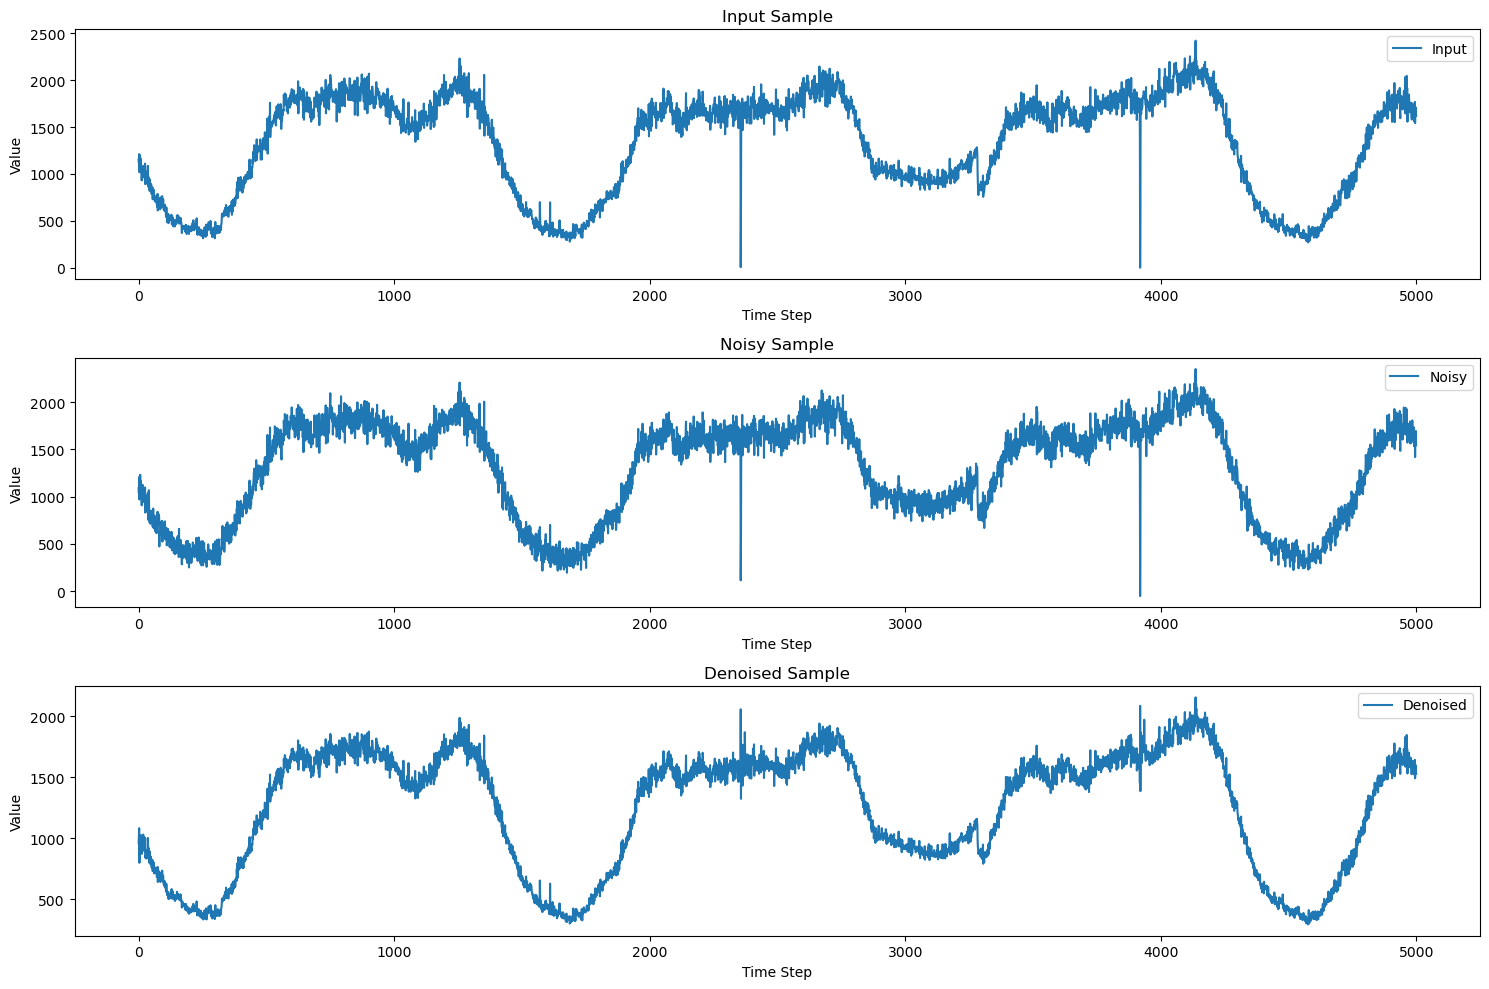

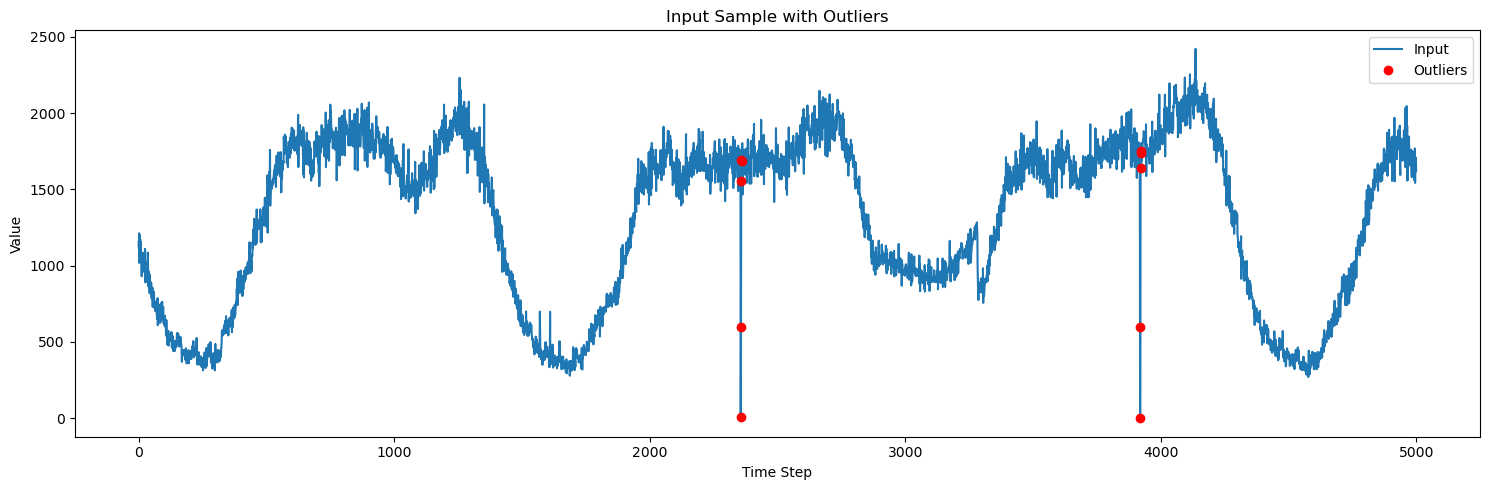

eval timesteps tensor([ 63,   2, 619,  93, 584, 615,  78,  22, 698, 209, 649, 509, 578, 165,
        598, 285])
Best threshold: tensor(369.5092)
Best F1 score: 0.21052631578947367
Best AUPRC score: 0.12364705882352942
Best Precision score: 1.0
Best Recall score: 0.11764705882352941
Best threshold: tensor(369.5092)
Best F1 score: 0.19607843137254902
Best AUPRC score: 0.11689565217391304
Best Precision score: 1.0
Best Recall score: 0.10869565217391304
Best threshold: tensor(369.5092)
Best F1 score: 0.16129032258064516
Best AUPRC score: 0.0846047619047619
Best Precision score: 0.8333333333333334
Best Recall score: 0.08928571428571429
Best threshold: tensor(369.5092)
Best F1 score: 0.16393442622950818
Best AUPRC score: 0.09948571428571429
Best Precision score: 1.0
Best Recall score: 0.08928571428571429
Best threshold: tensor(369.5092)
Best F1 score: 0.15384615384615385
Best AUPRC score: 0.10093333333333332
Best Precision score: 1.0
Best Recall score: 0.08333333333333333
Best threshold: tensor(369.5092)
Best F1 score: 0.1553398058252427
Best AUPRC score: 0.10161052631578947
Best Precision score: 1.0
Best Recall score: 0.08421052631578947
Best threshold: tensor(369.5092)
Best F1 score: 0.1553398058252427
Best AUPRC score: 0.10161052631578947
Best Precision score: 1.0
Best Recall score: 0.08421052631578947
Best threshold: tensor(369.5092)
Best F1 score: 0.1694915254237288
Best AUPRC score: 0.1121925925925926
Best Precision score: 1.0
Best Recall score: 0.09259259259259259
Best threshold: tensor(369.5092)
Best F1 score: 0.17204301075268819
Best AUPRC score: 0.09985608465608466
Best Precision score: 0.8888888888888888
Best Recall score: 0.09523809523809523
Best threshold: tensor(263.9352)
Best F1 score: 0.17391304347826086
Best AUPRC score: 0.11043809523809524
Best Precision score: 1.0
Best Recall score: 0.09523809523809523
Best threshold: tensor(369.5092)
Best F1 score: 0.17391304347826086
Best AUPRC score: 0.11043809523809524
Best Precision score: 1.0
Best Recall score: 0.09523809523809523
Best threshold: tensor(369.5092)
Best F1 score: 0.175
Best AUPRC score: 0.09806944444444445
Best Precision score: 0.875
Best Recall score: 0.09722222222222222
Best threshold: tensor(263.9352)
Best F1 score: 0.2028985507246377
Best AUPRC score: 0.1239032258064516
Best Precision score: 1.0
Best Recall score: 0.11290322580645161
Best threshold: tensor(369.5092)
Best F1 score: 0.2222222222222222
Best AUPRC score: 0.1376
Best Precision score: 1.0
Best Recall score: 0.125
Best threshold: tensor(369.5092)
Best F1 score: 0.3076923076923077
Best AUPRC score: 0.1659142857142857
Best Precision score: 0.8571428571428571
Best Recall score: 0.1875
Best threshold: tensor(263.9352)
Best F1 score: 0.2962962962962963
Best AUPRC score: 0.17771304347826086
Best Precision score: 1.0
Best Recall score: 0.17391304347826086
F1 score: 0.1931140788460761
AUPRC score: 0.11655702752007133
Precision score: 0.9658978174603176
Recall score: 0.10821961845922476

## NAB
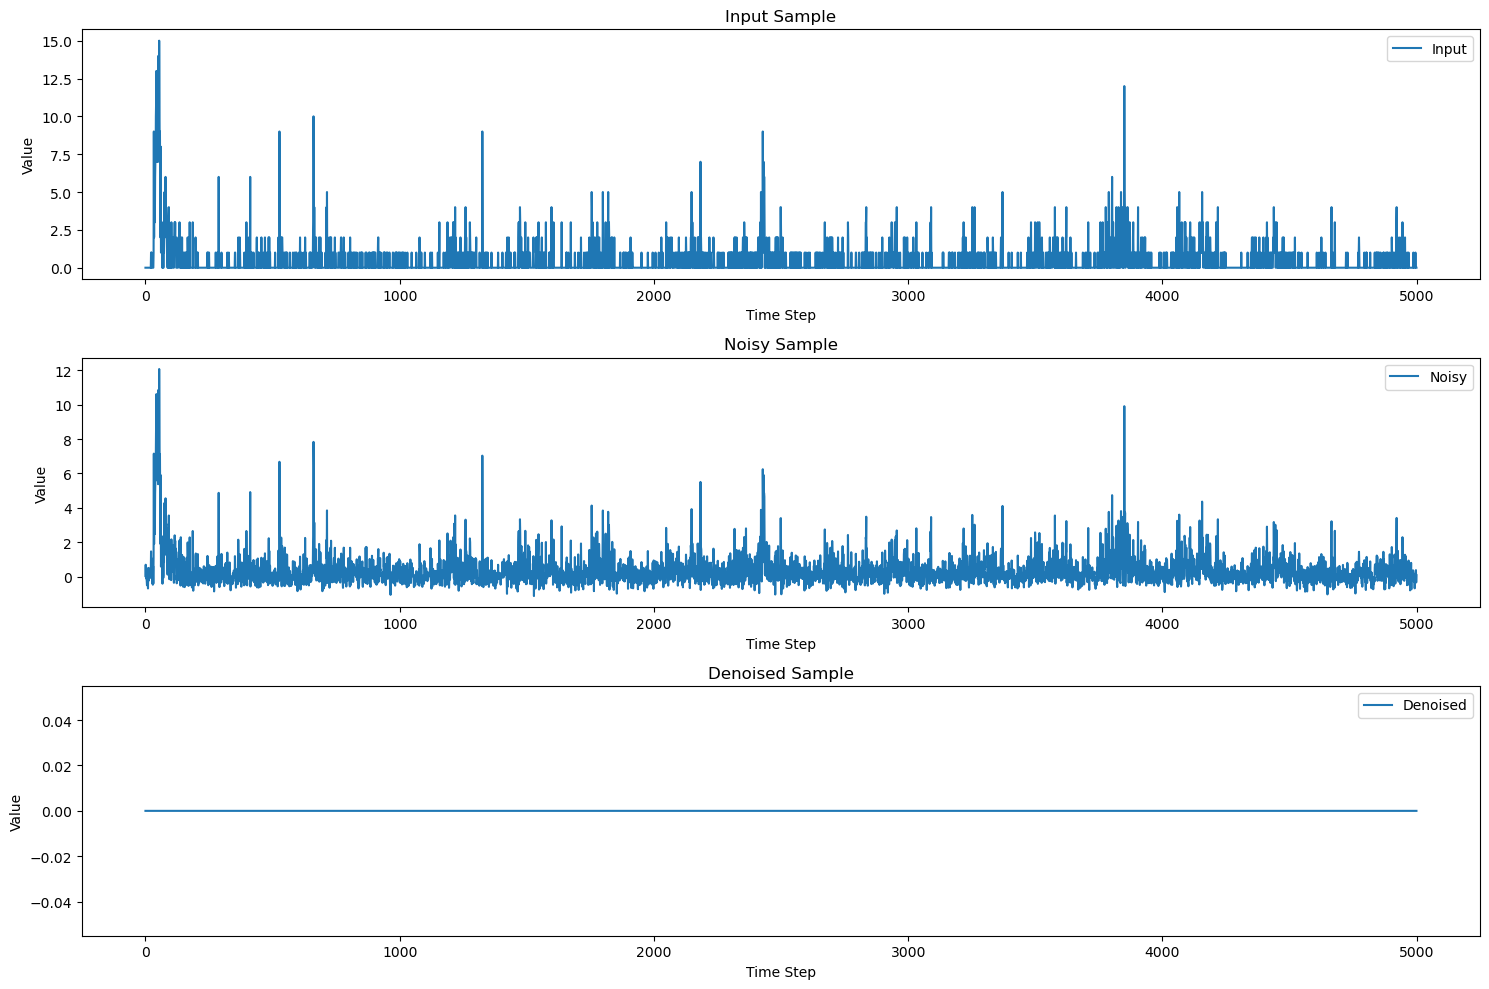
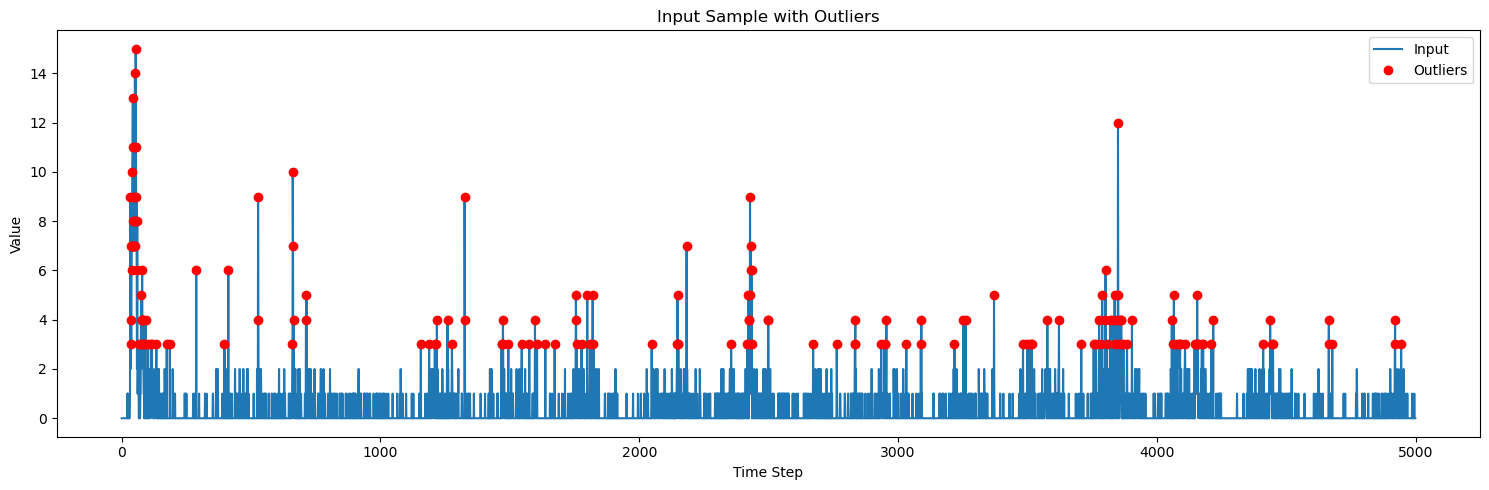
eval timesteps tensor([634, 451, 626, 721])
Best threshold: tensor(2.0974)
Best F1 score: 0.21176470588235294
Best AUPRC score: 0.08645831779102034
Best Precision score: 0.25280898876404495
Best Recall score: 0.18218623481781376
Best threshold: tensor(1.1039)
Best F1 score: 0.027586206896551724
Best AUPRC score: 0.015505956613219183
Best Precision score: 0.01675977653631285
Best Recall score: 0.07792207792207792
Best threshold: tensor(0.5520)
Best F1 score: 0.1319073083778966
Best AUPRC score: 0.08149127348806288
Best Precision score: 0.08638132295719844
Best Recall score: 0.27889447236180903
Best threshold: tensor(0.5520)
Best F1 score: 0.13012895662368112
Best AUPRC score: 0.08106765017749298
Best Precision score: 0.08486238532110092
Best Recall score: 0.27889447236180903
F1 score: 0.1253467944451206
AUPRC score: 0.06613079951744885
Precision score: 0.11020311839466429
Recall score: 0.20447431436587743

# Complete Evaluation

In [4]:
class Config:
    def __init__(self, config_dict):
        for key, value in config_dict.items():
            setattr(self, key, value)

In [5]:
# training testing imports 
import train_test_fonctions
from train_test_fonctions import calculate_f1_auprc_score, plot_samples, plot_predictions, trainer, tester, train_tracker, z_score_outliers, modified_z_score_outliers, iqr_outliers, iqr_collective_outliers
from train_test_fonctions import train_model, test_model, process_directory, trainer_all_in_one

## WSD dataset

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
from pytorch_tcn import TCN  # Import the TCN class from pytorch-tcn

sequence_length = 5000
input_size = 1  # Assuming 1D time series data

base_config = {
  "data_path": "../datasets/UTS/WSD/107",
  "output_dir": "output_WSD",
  "train_batch_size": 16,
  "eval_batch_size": 1,
  "num_epochs": 5,
  
  "learning_rate": 0.0001,
  "num_timesteps": 1000,
  "beta_schedule": "linear",
  "embedding_size": 128,
  "hidden_size": 128,
  "hidden_layers": 3,
  "time_embedding": "sinusoidal",
  "input_embedding": "sinusoidal",
  "save_eval_step": 10,
  "experiment_name": "NonName",
  "beta_start": 0.0001,
  "beta_end": 0.02,
  "save_model_epochs": 1
}

In [6]:
import os

data_folder = "../datasets/UTS/WSD"

for root, dirs, files in os.walk(data_folder):
    for dir in dirs:
        data_path = os.path.join(data_folder, dir)
    
        # change datapath in the config
        base_config["data_path"] = data_path
        base_config["output_dir"] = os.path.join("output_WSD", dir)
        
        print(base_config)
        # Create Config object
        config = Config(base_config)
        
        print(config.data_path)

        # Initialize the new TCN model
        model = TCN(
            num_inputs=input_size,  # Number of input channels
            num_channels=[64, 128, 256, 512,256,128,64,1],  # Number of channels in each residual block
            kernel_size=3,  # Size of the convolution kernel
            dilations=None,  # Dilation sizes
            dilation_reset=None,  # Reset dilation size
            dropout=0.2,  # Dropout rate
            causal=True,  # Causal convolutions for real-time applications
            use_norm='weight_norm',  # Normalization method
            activation='relu',  # Activation function
            kernel_initializer='xavier_uniform',  # Weight initializer
            use_skip_connections=False,  # Skip connections
            input_shape='NLC',  # Input shape format ('NCL' or 'NLC') [16, 5000, 1] for NLC
            embedding_shapes=None,  # Embedding shapes
            embedding_mode='add',  # Embedding mode ('add' or 'concat')
            use_gate=False,  # Use gated linear unit
            lookahead=0,  # Lookahead for future time steps
            output_projection=None,  # Output projection
            output_activation=None,  # Output activation
        )

        noise_scheduler = NoiseScheduler(
            num_timesteps=config.num_timesteps,
            beta_start=config.beta_start,
            beta_end=config.beta_end,
            beta_schedule=config.beta_schedule
        )

        # Set up dataset and dataloader
        dataset = TimeSeriesDataset(config.data_path,sequence_length=5000, stride=500,normalize=False)

        # Set up dataset and dataloader for test data
        test_dataset = TimeSeriesTestDataset(config.data_path, sequence_length=5000, stride=500, normalize=False) #mean=dataset.mean, std=dataset.std)

        #================================================================================================
        # define a pd dataframe to save the results, with the data folder name as the index
        results_df = pd.DataFrame(columns=["data_folder", "average_f1", "average_auprc"])
        results_df.set_index("data_folder", inplace=True)
        
        # train the model and test it
        model, losses = trainer(config, model, noise_scheduler, dataset)
        train_tracker(losses,config, model, dataset)
        average_f1, average_auprc = tester(config, model, noise_scheduler, test_dataset)
        
        # save the results in the dataframe
        results_df.loc[dir] = [average_f1, average_auprc]
        
        print("training and results done for", dir)
        
# save the results in a csv file in outtput directory
results_df.to_csv(os.path.join(config.output_dir, "results.csv"))


{'data_path': '../datasets/UTS/WSD/0', 'output_dir': 'output_WSD/0', 'train_batch_size': 16, 'eval_batch_size': 1, 'num_epochs': 5, 'learning_rate': 0.0001, 'num_timesteps': 1000, 'beta_schedule': 'linear', 'embedding_size': 128, 'hidden_size': 128, 'hidden_layers': 3, 'time_embedding': 'sinusoidal', 'input_embedding': 'sinusoidal', 'save_eval_step': 10, 'experiment_name': 'NonName', 'beta_start': 0.0001, 'beta_end': 0.02, 'save_model_epochs': 1}
../datasets/UTS/WSD/0
Training model...


100%|██████████| 5/5 [00:57<00:00, 11.54s/it]


TypeError: train_tracker() missing 1 required positional argument: 'dataset'

# NAB dataset - all in one 

In [8]:
# config for NAB dataset
base_config = {
  "data_path":  "../datasets/UTS/NAB",
  "output_dir": "output_NAB_simplex3",
  "train_batch_size": 3,
  "eval_batch_size": 1,
  "num_epochs": 20,
  
  "learning_rate": 0.0001,
  "num_timesteps": 100,
  "beta_schedule": "linear",
  "embedding_size": 128,
  "hidden_size": 128,
  "hidden_layers": 3,
  "time_embedding": "sinusoidal",
  "input_embedding": "sinusoidal",
  "save_eval_step": 10,
  "experiment_name": "NonName",
  "beta_start": 0.05,
  "beta_end": 0.4,
  "save_model_epochs": 1
}

sequence_length = 2500
input_size = 1  # Assuming 1D time series data
stride = 100


In [9]:
# all in one training and testing
import os
    
config = Config(base_config)

# Initialize the new TCN model
model = TCN(
    num_inputs=input_size,  # Number of input channels
    num_channels=[64, 128,256,512,256,128,64,1],  # Number of channels in each residual block
    kernel_size=3,  # Size of the convolution kernel
    dilations=None,  # Dilation sizes
    dilation_reset=None,  # Reset dilation size
    dropout=0.2,  # Dropout rate
    causal=True,  # Causal convolutions for real-time applications
    use_norm='weight_norm',  # Normalization method
    activation='relu',  # Activation function
    kernel_initializer='xavier_uniform',  # Weight initializer
    use_skip_connections=False,  # Skip connections
    input_shape='NLC',  # Input shape format ('NCL' or 'NLC') [16, 5000, 1] for NLC
    embedding_shapes=None,  # Embedding shapes
    embedding_mode='add',  # Embedding mode ('add' or 'concat')
    use_gate=False,  # Use gated linear unit
    lookahead=0,  # Lookahead for future time steps
    output_projection=None,  # Output projection
    output_activation=None,  # Output activation
)



noise_scheduler = SimplexNoiseScheduler(
    num_timesteps=config.num_timesteps,
    beta_start=config.beta_start,
    beta_end=config.beta_end,
    beta_schedule=config.beta_schedule
)

data_folder = "../datasets/UTS/NAB"

#================================================================================================
# train the model and test it

model, losses = trainer_all_in_one(sequence_length, stride, base_config, config, model, noise_scheduler, data_folder)


Training model...


  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 4367.775390625, 'epoch': 0}
{'loss': 903.3317260742188, 'epoch': 0}
{'loss': 82.71366882324219, 'epoch': 0}
{'loss': 0.8927446007728577, 'epoch': 0}
{'loss': 621.6316528320312, 'epoch': 0}
{'loss': 285.0562744140625, 'epoch': 0}
{'loss': 22.774429321289062, 'epoch': 0}
{'loss': 72.24667358398438, 'epoch': 0}
{'loss': 2.490900754928589, 'epoch': 0}


  5%|▌         | 1/20 [00:50<15:54, 50.23s/it]

{'loss': 183.4228973388672, 'epoch': 0}
{'loss': 6364.7734375, 'epoch': 1}
{'loss': 1669.7193603515625, 'epoch': 1}
{'loss': 20.94704818725586, 'epoch': 1}
{'loss': 0.9385534524917603, 'epoch': 1}
{'loss': 297.75335693359375, 'epoch': 1}
{'loss': 233.4142608642578, 'epoch': 1}
{'loss': 17.923419952392578, 'epoch': 1}
{'loss': 530.0842895507812, 'epoch': 1}
{'loss': 3.342353343963623, 'epoch': 1}


 10%|█         | 2/20 [01:41<15:11, 50.66s/it]

{'loss': 152.8917236328125, 'epoch': 1}
{'loss': 4190.3095703125, 'epoch': 2}
{'loss': 1896.7271728515625, 'epoch': 2}
{'loss': 41.95516586303711, 'epoch': 2}
{'loss': 0.9290146231651306, 'epoch': 2}
{'loss': 235.65603637695312, 'epoch': 2}
{'loss': 198.4425811767578, 'epoch': 2}
{'loss': 21.677059173583984, 'epoch': 2}
{'loss': 406.08819580078125, 'epoch': 2}
{'loss': 3.5607197284698486, 'epoch': 2}


 15%|█▌        | 3/20 [02:31<14:21, 50.69s/it]

{'loss': 123.60257720947266, 'epoch': 2}
{'loss': 3637.67626953125, 'epoch': 3}
{'loss': 4794.9921875, 'epoch': 3}
{'loss': 59.208675384521484, 'epoch': 3}
{'loss': 0.6724674701690674, 'epoch': 3}
{'loss': 421.3949279785156, 'epoch': 3}
{'loss': 299.09051513671875, 'epoch': 3}
{'loss': 16.743330001831055, 'epoch': 3}
{'loss': 294.0350036621094, 'epoch': 3}
{'loss': 3.994560718536377, 'epoch': 3}


 20%|██        | 4/20 [03:22<13:33, 50.83s/it]

{'loss': 156.76846313476562, 'epoch': 3}
{'loss': 3484.3076171875, 'epoch': 4}
{'loss': 3025.39599609375, 'epoch': 4}
{'loss': 59.186851501464844, 'epoch': 4}
{'loss': 0.9088580012321472, 'epoch': 4}
{'loss': 310.5234680175781, 'epoch': 4}
{'loss': 281.4302673339844, 'epoch': 4}
{'loss': 12.989617347717285, 'epoch': 4}
{'loss': 251.4112548828125, 'epoch': 4}
{'loss': 10.64473819732666, 'epoch': 4}


 25%|██▌       | 5/20 [04:14<12:43, 50.93s/it]

{'loss': 46.29600143432617, 'epoch': 4}
{'loss': 4302.794921875, 'epoch': 5}
{'loss': 2194.0234375, 'epoch': 5}
{'loss': 32.306846618652344, 'epoch': 5}
{'loss': 1.2350304126739502, 'epoch': 5}
{'loss': 388.9276428222656, 'epoch': 5}
{'loss': 344.8832702636719, 'epoch': 5}
{'loss': 21.560739517211914, 'epoch': 5}
{'loss': 387.04278564453125, 'epoch': 5}
{'loss': 2.4062087535858154, 'epoch': 5}


 30%|███       | 6/20 [05:05<11:57, 51.21s/it]

{'loss': 97.2967529296875, 'epoch': 5}
{'loss': 4609.85302734375, 'epoch': 6}
{'loss': 11741.68359375, 'epoch': 6}
{'loss': 27.365541458129883, 'epoch': 6}
{'loss': 0.800609290599823, 'epoch': 6}
{'loss': 259.0572814941406, 'epoch': 6}
{'loss': 211.43797302246094, 'epoch': 6}
{'loss': 20.80179214477539, 'epoch': 6}
{'loss': 540.5459594726562, 'epoch': 6}
{'loss': 12.16567325592041, 'epoch': 6}


 35%|███▌      | 7/20 [05:57<11:06, 51.29s/it]

{'loss': 194.30841064453125, 'epoch': 6}
{'loss': 6274.76416015625, 'epoch': 7}
{'loss': 1977.8870849609375, 'epoch': 7}
{'loss': 45.58148193359375, 'epoch': 7}
{'loss': 0.644883394241333, 'epoch': 7}
{'loss': 435.3463439941406, 'epoch': 7}
{'loss': 1241.7120361328125, 'epoch': 7}
{'loss': 17.277854919433594, 'epoch': 7}
{'loss': 508.3788146972656, 'epoch': 7}
{'loss': 8.297985076904297, 'epoch': 7}


 40%|████      | 8/20 [06:49<10:17, 51.45s/it]

{'loss': 117.35845184326172, 'epoch': 7}
{'loss': 3243.21142578125, 'epoch': 8}
{'loss': 2401.428466796875, 'epoch': 8}
{'loss': 53.22374725341797, 'epoch': 8}
{'loss': 0.6836749315261841, 'epoch': 8}
{'loss': 276.4109191894531, 'epoch': 8}
{'loss': 455.148681640625, 'epoch': 8}
{'loss': 21.5670108795166, 'epoch': 8}
{'loss': 239.1688232421875, 'epoch': 8}
{'loss': 1.8276294469833374, 'epoch': 8}


 45%|████▌     | 9/20 [07:40<09:27, 51.60s/it]

{'loss': 146.896240234375, 'epoch': 8}
{'loss': 4944.97509765625, 'epoch': 9}
{'loss': 6868.9521484375, 'epoch': 9}
{'loss': 13.375612258911133, 'epoch': 9}
{'loss': 0.6590169072151184, 'epoch': 9}
{'loss': 276.95648193359375, 'epoch': 9}
{'loss': 241.3229522705078, 'epoch': 9}
{'loss': 15.61331844329834, 'epoch': 9}
{'loss': 539.9531860351562, 'epoch': 9}
{'loss': 5.05461311340332, 'epoch': 9}


 50%|█████     | 10/20 [08:33<08:37, 51.76s/it]

{'loss': 200.95542907714844, 'epoch': 9}
{'loss': 4592.7041015625, 'epoch': 10}
{'loss': 2870.581298828125, 'epoch': 10}
{'loss': 58.73531723022461, 'epoch': 10}
{'loss': 1.2692103385925293, 'epoch': 10}
{'loss': 437.39276123046875, 'epoch': 10}
{'loss': 561.4515380859375, 'epoch': 10}
{'loss': 16.902849197387695, 'epoch': 10}
{'loss': 413.9655456542969, 'epoch': 10}
{'loss': 15.672210693359375, 'epoch': 10}


 55%|█████▌    | 11/20 [09:25<07:46, 51.81s/it]

{'loss': 159.3217315673828, 'epoch': 10}
{'loss': 4741.03271484375, 'epoch': 11}
{'loss': 3816.691162109375, 'epoch': 11}
{'loss': 65.3936538696289, 'epoch': 11}
{'loss': 1.9997448921203613, 'epoch': 11}
{'loss': 106.07344055175781, 'epoch': 11}
{'loss': 376.4784240722656, 'epoch': 11}
{'loss': 17.22315788269043, 'epoch': 11}
{'loss': 626.2429809570312, 'epoch': 11}
{'loss': 9.813314437866211, 'epoch': 11}


 60%|██████    | 12/20 [10:16<06:53, 51.69s/it]

{'loss': 140.1807098388672, 'epoch': 11}
{'loss': 4859.82470703125, 'epoch': 12}
{'loss': 2983.84033203125, 'epoch': 12}
{'loss': 49.752960205078125, 'epoch': 12}
{'loss': 3.034567356109619, 'epoch': 12}
{'loss': 195.30624389648438, 'epoch': 12}
{'loss': 424.2760925292969, 'epoch': 12}
{'loss': 13.610873222351074, 'epoch': 12}
{'loss': 512.1506958007812, 'epoch': 12}
{'loss': 6.919378280639648, 'epoch': 12}


 65%|██████▌   | 13/20 [11:07<06:00, 51.52s/it]

{'loss': 147.36964416503906, 'epoch': 12}
{'loss': 5032.58544921875, 'epoch': 13}
{'loss': 2010.833740234375, 'epoch': 13}
{'loss': 46.04585647583008, 'epoch': 13}
{'loss': 4.249692916870117, 'epoch': 13}
{'loss': 323.1948547363281, 'epoch': 13}
{'loss': 199.385009765625, 'epoch': 13}
{'loss': 14.102887153625488, 'epoch': 13}
{'loss': 428.2474060058594, 'epoch': 13}
{'loss': 7.336456775665283, 'epoch': 13}


 70%|███████   | 14/20 [12:00<05:11, 51.91s/it]

{'loss': 118.51181030273438, 'epoch': 13}
{'loss': 2614.013671875, 'epoch': 14}
{'loss': 2334.960693359375, 'epoch': 14}
{'loss': 42.159942626953125, 'epoch': 14}
{'loss': 3.4604430198669434, 'epoch': 14}
{'loss': 333.6456604003906, 'epoch': 14}
{'loss': 547.2410888671875, 'epoch': 14}
{'loss': 18.501544952392578, 'epoch': 14}
{'loss': 656.2125244140625, 'epoch': 14}
{'loss': 6.0005269050598145, 'epoch': 14}


 75%|███████▌  | 15/20 [12:52<04:19, 51.82s/it]

{'loss': 148.4185028076172, 'epoch': 14}
{'loss': 3043.047119140625, 'epoch': 15}
{'loss': 3020.624755859375, 'epoch': 15}
{'loss': 41.47666549682617, 'epoch': 15}
{'loss': 3.6830623149871826, 'epoch': 15}
{'loss': 467.64422607421875, 'epoch': 15}
{'loss': 361.09979248046875, 'epoch': 15}
{'loss': 21.227304458618164, 'epoch': 15}
{'loss': 542.1402587890625, 'epoch': 15}
{'loss': 8.254124641418457, 'epoch': 15}


 80%|████████  | 16/20 [13:44<03:27, 51.97s/it]

{'loss': 122.47596740722656, 'epoch': 15}
{'loss': 4957.14208984375, 'epoch': 16}
{'loss': 1909.04736328125, 'epoch': 16}
{'loss': 57.375186920166016, 'epoch': 16}
{'loss': 3.8994028568267822, 'epoch': 16}
{'loss': 471.5002746582031, 'epoch': 16}
{'loss': 442.068603515625, 'epoch': 16}
{'loss': 26.73182487487793, 'epoch': 16}
{'loss': 413.5160217285156, 'epoch': 16}
{'loss': 6.704047679901123, 'epoch': 16}


 85%|████████▌ | 17/20 [14:37<02:37, 52.45s/it]

{'loss': 196.14906311035156, 'epoch': 16}
{'loss': 2822.1103515625, 'epoch': 17}
{'loss': 3036.7099609375, 'epoch': 17}
{'loss': 45.35298156738281, 'epoch': 17}
{'loss': 3.695284605026245, 'epoch': 17}
{'loss': 476.508056640625, 'epoch': 17}
{'loss': 518.2080078125, 'epoch': 17}
{'loss': 38.18426513671875, 'epoch': 17}
{'loss': 483.2285461425781, 'epoch': 17}
{'loss': 4.148276329040527, 'epoch': 17}


 90%|█████████ | 18/20 [15:29<01:44, 52.20s/it]

{'loss': 87.73819732666016, 'epoch': 17}
{'loss': 3727.494873046875, 'epoch': 18}
{'loss': 2083.833740234375, 'epoch': 18}
{'loss': 44.073692321777344, 'epoch': 18}
{'loss': 3.3327672481536865, 'epoch': 18}
{'loss': 327.2103576660156, 'epoch': 18}
{'loss': 531.6163330078125, 'epoch': 18}
{'loss': 16.334997177124023, 'epoch': 18}
{'loss': 562.397216796875, 'epoch': 18}
{'loss': 6.93393087387085, 'epoch': 18}


 95%|█████████▌| 19/20 [16:20<00:51, 51.89s/it]

{'loss': 199.50048828125, 'epoch': 18}
{'loss': 3229.333251953125, 'epoch': 19}
{'loss': 806.5955200195312, 'epoch': 19}
{'loss': 44.161582946777344, 'epoch': 19}
{'loss': 4.374378204345703, 'epoch': 19}
{'loss': 388.3395690917969, 'epoch': 19}
{'loss': 194.5783233642578, 'epoch': 19}
{'loss': 13.700335502624512, 'epoch': 19}
{'loss': 262.63226318359375, 'epoch': 19}
{'loss': 7.503151893615723, 'epoch': 19}


100%|██████████| 20/20 [17:12<00:00, 51.62s/it]

{'loss': 193.9200439453125, 'epoch': 19}



Processing directory: Twitter_volume_AAPL
Number of batches: 3


100%|██████████| 3/3 [00:00<00:00, 32.68it/s]



IQR outliers classification report for Twitter_volume_AAPL
              precision    recall  f1-score   support

         0.0       0.97      0.85      0.91      7102
         1.0       0.15      0.45      0.22       398

    accuracy                           0.83      7500
   macro avg       0.56      0.65      0.56      7500
weighted avg       0.92      0.83      0.87      7500

ROC AUC: 0.6890

Processing directory: Twitter_volume_AMZN
Number of batches: 3


100%|██████████| 3/3 [00:00<00:00, 34.64it/s]



IQR outliers classification report for Twitter_volume_AMZN
              precision    recall  f1-score   support

         0.0       0.92      0.74      0.82      6708
         1.0       0.17      0.44      0.24       792

    accuracy                           0.71      7500
   macro avg       0.54      0.59      0.53      7500
weighted avg       0.84      0.71      0.76      7500

ROC AUC: 0.6162

Processing directory: Twitter_volume_CRM
Number of batches: 3


100%|██████████| 3/3 [00:00<00:00, 34.47it/s]



IQR outliers classification report for Twitter_volume_CRM
              precision    recall  f1-score   support

         0.0       0.97      0.96      0.97      7151
         1.0       0.32      0.34      0.33       349

    accuracy                           0.94      7500
   macro avg       0.64      0.65      0.65      7500
weighted avg       0.94      0.94      0.94      7500

ROC AUC: 0.6883

Processing directory: Twitter_volume_CVS
Number of batches: 3


100%|██████████| 3/3 [00:00<00:00, 34.61it/s]


IQR outliers classification report for Twitter_volume_CVS
              precision    recall  f1-score   support

         0.0       0.82      0.03      0.05      6855
         1.0       0.08      0.94      0.15       645

    accuracy                           0.11      7500
   macro avg       0.45      0.48      0.10      7500
weighted avg       0.76      0.11      0.06      7500

ROC AUC: 0.4197

Processing directory: Twitter_volume_FB
Number of batches: 3


100%|██████████| 3/3 [00:00<00:00, 31.05it/s]


IQR outliers classification report for Twitter_volume_FB


              precision    recall  f1-score   support

         0.0       0.88      0.85      0.87      6708
         1.0       0.04      0.06      0.05       792

    accuracy                           0.77      7500
   macro avg       0.46      0.46      0.46      7500
weighted avg       0.80      0.77      0.78      7500

ROC AUC: 0.3904

Processing directory: Twitter_volume_GOOG
Number of batches: 3


100%|██████████| 3/3 [00:00<00:00, 31.29it/s]



IQR outliers classification report for Twitter_volume_GOOG
              precision    recall  f1-score   support

         0.0       0.98      0.89      0.93      7102
         1.0       0.25      0.68      0.37       398

    accuracy                           0.88      7500
   macro avg       0.62      0.78      0.65      7500
weighted avg       0.94      0.88      0.90      7500

ROC AUC: 0.8904

Processing directory: Twitter_volume_IBM
Number of batches: 3


100%|██████████| 3/3 [00:00<00:00, 31.27it/s]



IQR outliers classification report for Twitter_volume_IBM
              precision    recall  f1-score   support

         0.0       0.93      0.95      0.94      6902
         1.0       0.18      0.12      0.14       598

    accuracy                           0.88      7500
   macro avg       0.55      0.54      0.54      7500
weighted avg       0.87      0.88      0.87      7500

ROC AUC: 0.5132

Processing directory: Twitter_volume_KO
Number of batches: 3


100%|██████████| 3/3 [00:00<00:00, 34.75it/s]



IQR outliers classification report for Twitter_volume_KO
              precision    recall  f1-score   support

         0.0       0.86      0.90      0.88      6440
         1.0       0.13      0.09      0.11      1060

    accuracy                           0.78      7500
   macro avg       0.49      0.50      0.49      7500
weighted avg       0.75      0.78      0.77      7500

ROC AUC: 0.4908

Processing directory: Twitter_volume_PFE
Number of batches: 3


100%|██████████| 3/3 [00:00<00:00, 32.54it/s]



IQR outliers classification report for Twitter_volume_PFE
              precision    recall  f1-score   support

         0.0       0.94      0.36      0.52      7102
         1.0       0.05      0.56      0.09       398

    accuracy                           0.37      7500
   macro avg       0.49      0.46      0.30      7500
weighted avg       0.89      0.37      0.50      7500

ROC AUC: 0.4954

Processing directory: Twitter_volume_UPS
Number of batches: 3


100%|██████████| 3/3 [00:00<00:00, 34.46it/s]



IQR outliers classification report for Twitter_volume_UPS
              precision    recall  f1-score   support

         0.0       0.97      0.96      0.96      7182
         1.0       0.24      0.28      0.26       318

    accuracy                           0.93      7500
   macro avg       0.60      0.62      0.61      7500
weighted avg       0.94      0.93      0.93      7500

ROC AUC: 0.7265

Overall IQR outliers classification report
              precision    recall  f1-score   support

         0.0       0.94      0.66      0.77     69252
         1.0       0.10      0.45      0.16      5748

    accuracy                           0.64     75000
   macro avg       0.52      0.55      0.47     75000
weighted avg       0.87      0.64      0.72     75000



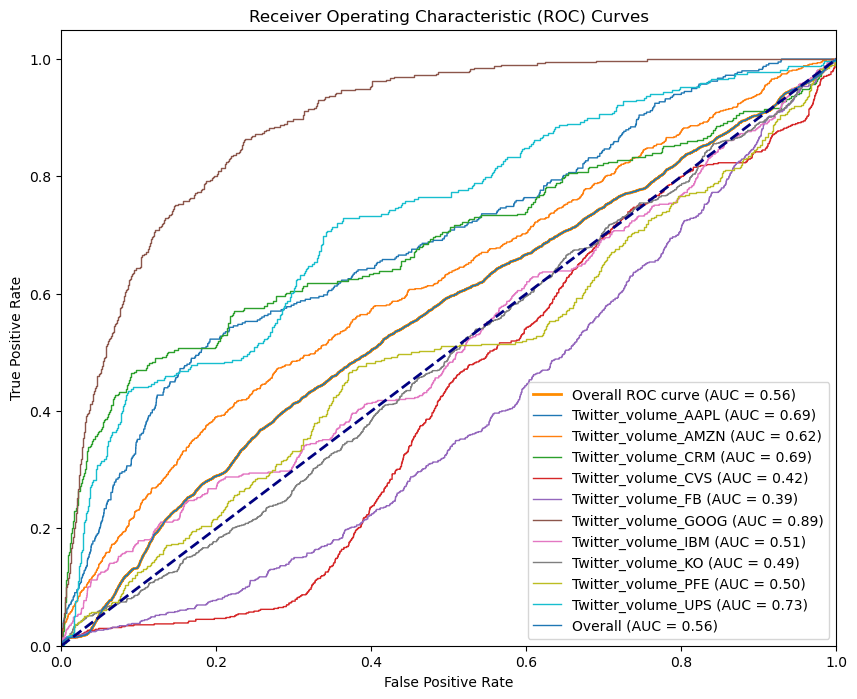


Overall ROC AUC: 0.5590


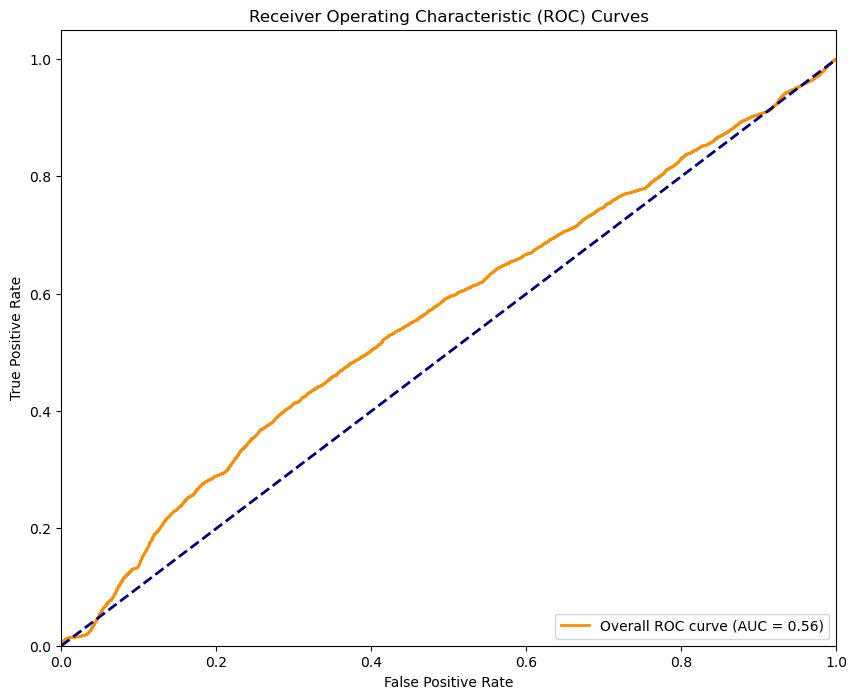

In [10]:
# evaluation with roc curve and classification report 

model.eval()
eval_batch_size = config.eval_batch_size

all_dir_results = []

for root, dirs, files in os.walk(data_folder):
    for dir in dirs:
        data_path = os.path.join(data_folder, dir)
        print(f"\nProcessing directory: {dir}")
    
        # change datapath in the config
        base_config["data_path"] = data_path
        config = Config(base_config)
        
        # Set up dataset and dataloader for test data
        test_dataset = TimeSeriesTestDataset(config.data_path, sequence_length=sequence_length , stride=sequence_length , normalize=False)
        print("Number of batches:", len(test_dataset))

        # Create dataloader for the test dataset
        test_dataloader = DataLoader(test_dataset, batch_size=config.eval_batch_size, shuffle=False, drop_last=True)

        all_labels = []
        all_scores = []

        for step, (sample, labels) in enumerate(tqdm(test_dataloader)):
            std_data = torch.std(sample)
            
            with torch.no_grad():
                timesteps = torch.tensor([50])
                
                noise = torch.randn_like(sample) 
                noisy_sample = noise_scheduler.add_noise(sample, noise, timesteps)
                
                noisy_sample = noisy_sample.unsqueeze(-1)
                sample = sample.unsqueeze(-1)
                denoised_sample = model(noisy_sample)

                # Calculate IQR outliers
                iqr_out, iqr_scores = iqr_outliers(sample, denoised_sample)
                
                labels = labels.cpu().numpy()

                # Store labels and scores
                all_labels.extend(labels.reshape(-1))
                all_scores.extend(iqr_scores.reshape(-1))

        # Calculate metrics for this directory
        fpr, tpr, thresholds = roc_curve(all_labels, all_scores)
        roc_auc = auc(fpr, tpr)
        
        print("\nIQR outliers classification report for", dir)
        print(classification_report(all_labels, (np.array(all_scores) > 2).astype(int)))
        print(f"ROC AUC: {roc_auc:.4f}")

        # Store results for this directory
        all_dir_results.append({
            'dir': dir,
            'labels': all_labels,
            'scores': all_scores,
            'fpr': fpr,
            'tpr': tpr,
            'roc_auc': roc_auc
        })

# Compute overall metrics
all_labels = np.concatenate([res['labels'] for res in all_dir_results])
all_scores = np.concatenate([res['scores'] for res in all_dir_results])

print("\nOverall IQR outliers classification report")
print(classification_report(all_labels, (np.array(all_scores) > 1.5).astype(int)))

fpr, tpr, thresholds = roc_curve(all_labels, all_scores)
roc_auc = auc(fpr, tpr)

all_dir_results.append({
    'dir': 'Overall',
    'labels': all_labels,
    'scores': all_scores,
    'fpr': fpr,
    'tpr': tpr,
    'roc_auc': roc_auc
})

#save the results in a csv file
results_df = pd.DataFrame(all_dir_results)
results_df.to_csv(os.path.join(config.output_dir, f"allinone_roc_resultsf{config.num_epochs}.csv"))

# Plot overall ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Overall ROC curve (AUC = {roc_auc:.2f})')

# Plot ROC curves for each directory
for res in all_dir_results:
    plt.plot(res['fpr'], res['tpr'], lw=1, label=f"{res['dir']} (AUC = {res['roc_auc']:.2f})")

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.savefig(os.path.join(config.output_dir, f"all_in_one_roc_curves_{config.num_epochs}.png"))
plt.show()


print(f"\nOverall ROC AUC: {roc_auc:.4f}")

# plot ans save only the overall roc curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Overall ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.savefig(os.path.join(config.output_dir, f"all_in_one_overall_roc_curve_{config.num_epochs}.png"))
plt.show()


In [12]:
# ROC AUC score distribution
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming all_dir_results is already populated with results from each directory

# Extract AUC-ROC scores for the box plot
auc_scores = [res['roc_auc'] for res in all_dir_results if res['dir'] != 'Overall']

# Create the figure
plt.figure(figsize=(6, 8))  # Adjust the width to make it narrower

# Plot AUC-ROC box plot
sns.boxplot(y=auc_scores, color='lightpink', width=0.3)  # Reduced width for a narrower box

# Set the y-axis limits from 0 to 1
plt.ylim(0, 1)

# Customize the plot
plt.ylabel('AUC-ROC')
plt.title('Distribution of AUC-ROC Scores')

# Remove x-axis label and ticks
plt.xlabel('')
plt.xticks([])

# Add a grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Save the figure
plt.tight_layout()
plt.savefig(os.path.join(config.output_dir, f"allin_one_auc_roc_distribution_{config.num_epochs}.png"))
plt.close()

# Print summary statistics
print(f"\nAUC-ROC Score Distribution:")
print(f"Mean: {np.mean(auc_scores):.4f}")
print(f"Median: {np.median(auc_scores):.4f}")
print(f"Min: {np.min(auc_scores):.4f}")
print(f"Max: {np.max(auc_scores):.4f}")


AUC-ROC Score Distribution:
Mean: 0.5920
Median: 0.5647
Min: 0.3904
Max: 0.8904



Processing directory: Twitter_volume_AAPL
Number of batches: 3
100%|██████████| 3/3 [00:00<00:00, 60.76it/s]
1
IQR outliers classification report for Twitter_volume_AAPL
              precision    recall  f1-score   support

         0.0       0.97      0.74      0.84      7102
         1.0       0.11      0.56      0.18       398

    accuracy                           0.73      7500
   macro avg       0.54      0.65      0.51      7500
weighted avg       0.92      0.73      0.81      7500

ROC AUC: 0.6941

Processing directory: Twitter_volume_AMZN
Number of batches: 3
100%|██████████| 3/3 [00:00<00:00, 73.51it/s]

IQR outliers classification report for Twitter_volume_AMZN
              precision    recall  f1-score   support

         0.0       0.92      0.50      0.65      6708
         1.0       0.13      0.63      0.21       792

    accuracy                           0.51      7500
   macro avg       0.52      0.56      0.43      7500
weighted avg       0.84      0.51      0.60      7500

ROC AUC: 0.6155

Processing directory: Twitter_volume_CRM
Number of batches: 3
100%|██████████| 3/3 [00:00<00:00, 71.32it/s]

IQR outliers classification report for Twitter_volume_CRM
              precision    recall  f1-score   support

         0.0       0.97      0.94      0.95      7151
         1.0       0.25      0.42      0.31       349

    accuracy                           0.91      7500
   macro avg       0.61      0.68      0.63      7500
weighted avg       0.94      0.91      0.92      7500

ROC AUC: 0.6705

Processing directory: Twitter_volume_CVS
Number of batches: 3
100%|██████████| 3/3 [00:00<00:00, 69.52it/s]

IQR outliers classification report for Twitter_volume_CVS
              precision    recall  f1-score   support

         0.0       0.82      0.02      0.03      6855
         1.0       0.08      0.96      0.16       645

    accuracy                           0.10      7500
   macro avg       0.45      0.49      0.09      7500
weighted avg       0.76      0.10      0.04      7500

ROC AUC: 0.4317

Processing directory: Twitter_volume_FB
Number of batches: 3
100%|██████████| 3/3 [00:00<00:00, 56.19it/s]

IQR outliers classification report for Twitter_volume_FB
              precision    recall  f1-score   support

         0.0       0.88      0.74      0.80      6708
         1.0       0.05      0.12      0.07       792

    accuracy                           0.68      7500
   macro avg       0.46      0.43      0.44      7500
weighted avg       0.79      0.68      0.73      7500

ROC AUC: 0.3928

Processing directory: Twitter_volume_GOOG
Number of batches: 3
100%|██████████| 3/3 [00:00<00:00, 73.58it/s]

IQR outliers classification report for Twitter_volume_GOOG
              precision    recall  f1-score   support

         0.0       0.99      0.79      0.88      7102
         1.0       0.18      0.81      0.29       398

    accuracy                           0.79      7500
   macro avg       0.58      0.80      0.58      7500
weighted avg       0.94      0.79      0.85      7500

ROC AUC: 0.8889

Processing directory: Twitter_volume_IBM
Number of batches: 3
100%|██████████| 3/3 [00:00<00:00, 74.17it/s]

IQR outliers classification report for Twitter_volume_IBM
              precision    recall  f1-score   support

         0.0       0.93      0.91      0.92      6902
         1.0       0.14      0.16      0.15       598

    accuracy                           0.85      7500
   macro avg       0.53      0.54      0.53      7500
weighted avg       0.86      0.85      0.86      7500

ROC AUC: 0.5057

Processing directory: Twitter_volume_KO
Number of batches: 3
100%|██████████| 3/3 [00:00<00:00, 52.89it/s]

IQR outliers classification report for Twitter_volume_KO
              precision    recall  f1-score   support

         0.0       0.86      0.83      0.84      6440
         1.0       0.13      0.16      0.14      1060

    accuracy                           0.73      7500
   macro avg       0.49      0.49      0.49      7500
weighted avg       0.75      0.73      0.74      7500

ROC AUC: 0.4915

Processing directory: Twitter_volume_PFE
Number of batches: 3
100%|██████████| 3/3 [00:00<00:00, 72.39it/s]

IQR outliers classification report for Twitter_volume_PFE
              precision    recall  f1-score   support

         0.0       0.93      0.15      0.26      7102
         1.0       0.05      0.79      0.09       398

    accuracy                           0.18      7500
   macro avg       0.49      0.47      0.18      7500
weighted avg       0.88      0.18      0.25      7500

ROC AUC: 0.4761

Processing directory: Twitter_volume_UPS
Number of batches: 3
100%|██████████| 3/3 [00:00<00:00, 71.15it/s]

IQR outliers classification report for Twitter_volume_UPS
              precision    recall  f1-score   support

         0.0       0.97      0.94      0.95      7182
         1.0       0.18      0.31      0.23       318

    accuracy                           0.91      7500
   macro avg       0.57      0.62      0.59      7500
weighted avg       0.93      0.91      0.92      7500

ROC AUC: 0.6968

Overall IQR outliers classification report
              precision    recall  f1-score   support

         0.0       0.93      0.66      0.77     69252
         1.0       0.10      0.45      0.16      5748

    accuracy                           0.64     75000
   macro avg       0.52      0.55      0.47     75000
weighted avg       0.87      0.64      0.72     75000


# NAB dataset - one by one 


Processing directory: Twitter_volume_AAPL


Training:   7%|▋         | 1/15 [00:01<00:25,  1.83s/it]

Epoch 1/15, Loss: 42229.1817


Training:  13%|█▎        | 2/15 [00:03<00:22,  1.73s/it]

Epoch 2/15, Loss: 44746.9711


Training:  20%|██        | 3/15 [00:05<00:20,  1.70s/it]

Epoch 3/15, Loss: 44116.6374


Training:  27%|██▋       | 4/15 [00:06<00:18,  1.68s/it]

Epoch 4/15, Loss: 51059.4768


Training:  33%|███▎      | 5/15 [00:08<00:16,  1.67s/it]

Epoch 5/15, Loss: 42262.9729


Training:  40%|████      | 6/15 [00:10<00:15,  1.67s/it]

Epoch 6/15, Loss: 39686.9302


Training:  47%|████▋     | 7/15 [00:11<00:13,  1.66s/it]

Epoch 7/15, Loss: 40202.4508


Training:  53%|█████▎    | 8/15 [00:13<00:11,  1.66s/it]

Epoch 8/15, Loss: 48795.3583


Training:  60%|██████    | 9/15 [00:15<00:09,  1.66s/it]

Epoch 9/15, Loss: 40022.3921


Training:  67%|██████▋   | 10/15 [00:16<00:08,  1.65s/it]

Epoch 10/15, Loss: 50303.5952


Training:  73%|███████▎  | 11/15 [00:18<00:06,  1.66s/it]

Epoch 11/15, Loss: 37414.5113


Training:  80%|████████  | 12/15 [00:20<00:04,  1.66s/it]

Epoch 12/15, Loss: 37674.8271


Training:  87%|████████▋ | 13/15 [00:21<00:03,  1.66s/it]

Epoch 13/15, Loss: 43820.3433


Training:  93%|█████████▎| 14/15 [00:23<00:01,  1.66s/it]

Epoch 14/15, Loss: 46041.1267


Training: 100%|██████████| 15/15 [00:25<00:00,  1.67s/it]


Epoch 15/15, Loss: 38407.6061


Testing: 100%|██████████| 3/3 [00:00<00:00, 91.08it/s]



Classification report for Twitter_volume_AAPL
              precision    recall  f1-score   support

         0.0       0.96      0.92      0.94      7102
         1.0       0.20      0.34      0.25       398

    accuracy                           0.89      7500
   macro avg       0.58      0.63      0.60      7500
weighted avg       0.92      0.89      0.90      7500

ROC AUC: 0.6942

Processing directory: Twitter_volume_AMZN


Training:   7%|▋         | 1/15 [00:01<00:23,  1.71s/it]

Epoch 1/15, Loss: 2916.5832


Training:  13%|█▎        | 2/15 [00:03<00:21,  1.69s/it]

Epoch 2/15, Loss: 2457.9761


Training:  20%|██        | 3/15 [00:05<00:20,  1.71s/it]

Epoch 3/15, Loss: 2221.2066


Training:  27%|██▋       | 4/15 [00:06<00:18,  1.72s/it]

Epoch 4/15, Loss: 5006.7796


Training:  33%|███▎      | 5/15 [00:08<00:16,  1.69s/it]

Epoch 5/15, Loss: 1245.4381


Training:  40%|████      | 6/15 [00:10<00:15,  1.68s/it]

Epoch 6/15, Loss: 1645.6886


Training:  47%|████▋     | 7/15 [00:11<00:13,  1.68s/it]

Epoch 7/15, Loss: 1302.2262


Training:  53%|█████▎    | 8/15 [00:13<00:11,  1.67s/it]

Epoch 8/15, Loss: 1720.0120


Training:  60%|██████    | 9/15 [00:15<00:10,  1.72s/it]

Epoch 9/15, Loss: 1319.0858


Training:  67%|██████▋   | 10/15 [00:16<00:08,  1.71s/it]

Epoch 10/15, Loss: 1320.3957


Training:  73%|███████▎  | 11/15 [00:18<00:06,  1.70s/it]

Epoch 11/15, Loss: 1164.3470


Training:  80%|████████  | 12/15 [00:20<00:05,  1.69s/it]

Epoch 12/15, Loss: 1228.7935


Training:  87%|████████▋ | 13/15 [00:22<00:03,  1.68s/it]

Epoch 13/15, Loss: 1168.2222


Training:  93%|█████████▎| 14/15 [00:23<00:01,  1.68s/it]

Epoch 14/15, Loss: 1022.3484


Training: 100%|██████████| 15/15 [00:25<00:00,  1.69s/it]


Epoch 15/15, Loss: 1005.8052


Testing: 100%|██████████| 3/3 [00:00<00:00, 71.87it/s]



Classification report for Twitter_volume_AMZN
              precision    recall  f1-score   support

         0.0       0.90      0.96      0.93      6708
         1.0       0.29      0.13      0.18       792

    accuracy                           0.87      7500
   macro avg       0.60      0.55      0.56      7500
weighted avg       0.84      0.87      0.85      7500

ROC AUC: 0.5458

Processing directory: Twitter_volume_CRM


Training:   7%|▋         | 1/15 [00:02<00:28,  2.04s/it]

Epoch 1/15, Loss: 25.3052


Training:  13%|█▎        | 2/15 [00:03<00:23,  1.82s/it]

Epoch 2/15, Loss: 20.0142


Training:  20%|██        | 3/15 [00:05<00:20,  1.75s/it]

Epoch 3/15, Loss: 21.9377


Training:  27%|██▋       | 4/15 [00:07<00:18,  1.72s/it]

Epoch 4/15, Loss: 21.7008


Training:  33%|███▎      | 5/15 [00:08<00:16,  1.70s/it]

Epoch 5/15, Loss: 18.4080


Training:  40%|████      | 6/15 [00:10<00:15,  1.69s/it]

Epoch 6/15, Loss: 21.1503


Training:  47%|████▋     | 7/15 [00:12<00:13,  1.69s/it]

Epoch 7/15, Loss: 21.7631


Training:  53%|█████▎    | 8/15 [00:13<00:11,  1.68s/it]

Epoch 8/15, Loss: 19.4407


Training:  60%|██████    | 9/15 [00:15<00:10,  1.68s/it]

Epoch 9/15, Loss: 19.6417


Training:  67%|██████▋   | 10/15 [00:17<00:08,  1.68s/it]

Epoch 10/15, Loss: 22.4654


Training:  73%|███████▎  | 11/15 [00:18<00:06,  1.68s/it]

Epoch 11/15, Loss: 19.3895


Training:  80%|████████  | 12/15 [00:20<00:05,  1.67s/it]

Epoch 12/15, Loss: 21.5155


Training:  87%|████████▋ | 13/15 [00:22<00:03,  1.67s/it]

Epoch 13/15, Loss: 18.8013


Training:  93%|█████████▎| 14/15 [00:23<00:01,  1.67s/it]

Epoch 14/15, Loss: 22.6219


Training: 100%|██████████| 15/15 [00:25<00:00,  1.70s/it]


Epoch 15/15, Loss: 22.9758


Testing: 100%|██████████| 3/3 [00:00<00:00, 64.70it/s]



Classification report for Twitter_volume_CRM
              precision    recall  f1-score   support

         0.0       0.97      0.93      0.95      7151
         1.0       0.24      0.42      0.30       349

    accuracy                           0.91      7500
   macro avg       0.60      0.68      0.63      7500
weighted avg       0.94      0.91      0.92      7500

ROC AUC: 0.6937

Processing directory: Twitter_volume_CVS


Training:   7%|▋         | 1/15 [00:01<00:24,  1.74s/it]

Epoch 1/15, Loss: 0.9503


Training:  13%|█▎        | 2/15 [00:03<00:22,  1.70s/it]

Epoch 2/15, Loss: 0.7965


Training:  20%|██        | 3/15 [00:05<00:20,  1.69s/it]

Epoch 3/15, Loss: 0.8122


Training:  27%|██▋       | 4/15 [00:06<00:18,  1.68s/it]

Epoch 4/15, Loss: 0.7513


Training:  33%|███▎      | 5/15 [00:08<00:16,  1.68s/it]

Epoch 5/15, Loss: 0.7758


Training:  40%|████      | 6/15 [00:10<00:15,  1.67s/it]

Epoch 6/15, Loss: 0.7781


Training:  47%|████▋     | 7/15 [00:11<00:13,  1.67s/it]

Epoch 7/15, Loss: 0.8875


Training:  53%|█████▎    | 8/15 [00:13<00:11,  1.67s/it]

Epoch 8/15, Loss: 0.8329


Training:  60%|██████    | 9/15 [00:15<00:10,  1.67s/it]

Epoch 9/15, Loss: 0.7527


Training:  67%|██████▋   | 10/15 [00:16<00:08,  1.67s/it]

Epoch 10/15, Loss: 0.8319


Training:  73%|███████▎  | 11/15 [00:18<00:06,  1.67s/it]

Epoch 11/15, Loss: 0.8411


Training:  80%|████████  | 12/15 [00:20<00:05,  1.67s/it]

Epoch 12/15, Loss: 0.8204


Training:  87%|████████▋ | 13/15 [00:21<00:03,  1.67s/it]

Epoch 13/15, Loss: 0.7496


Training:  93%|█████████▎| 14/15 [00:23<00:01,  1.67s/it]

Epoch 14/15, Loss: 0.8436


Training: 100%|██████████| 15/15 [00:25<00:00,  1.68s/it]


Epoch 15/15, Loss: 0.8707


Testing: 100%|██████████| 3/3 [00:00<00:00, 70.73it/s]



Classification report for Twitter_volume_CVS
              precision    recall  f1-score   support

         0.0       0.88      0.59      0.71      6855
         1.0       0.04      0.17      0.06       645

    accuracy                           0.55      7500
   macro avg       0.46      0.38      0.38      7500
weighted avg       0.81      0.55      0.65      7500

ROC AUC: 0.3770

Processing directory: Twitter_volume_FB


Training:   7%|▋         | 1/15 [00:01<00:24,  1.78s/it]

Epoch 1/15, Loss: 303.3623


Training:  13%|█▎        | 2/15 [00:03<00:22,  1.72s/it]

Epoch 2/15, Loss: 239.7331


Training:  20%|██        | 3/15 [00:05<00:20,  1.69s/it]

Epoch 3/15, Loss: 207.0647


Training:  27%|██▋       | 4/15 [00:06<00:18,  1.69s/it]

Epoch 4/15, Loss: 194.6175


Training:  33%|███▎      | 5/15 [00:08<00:16,  1.69s/it]

Epoch 5/15, Loss: 197.5281


Training:  40%|████      | 6/15 [00:10<00:15,  1.68s/it]

Epoch 6/15, Loss: 202.5353


Training:  47%|████▋     | 7/15 [00:11<00:13,  1.68s/it]

Epoch 7/15, Loss: 208.7332


Training:  53%|█████▎    | 8/15 [00:13<00:11,  1.68s/it]

Epoch 8/15, Loss: 174.3658


Training:  60%|██████    | 9/15 [00:15<00:10,  1.68s/it]

Epoch 9/15, Loss: 204.6901


Training:  67%|██████▋   | 10/15 [00:16<00:08,  1.68s/it]

Epoch 10/15, Loss: 188.2912


Training:  73%|███████▎  | 11/15 [00:18<00:06,  1.68s/it]

Epoch 11/15, Loss: 184.1315


Training:  80%|████████  | 12/15 [00:20<00:05,  1.67s/it]

Epoch 12/15, Loss: 176.3123


Training:  87%|████████▋ | 13/15 [00:21<00:03,  1.67s/it]

Epoch 13/15, Loss: 193.5103


Training:  93%|█████████▎| 14/15 [00:23<00:01,  1.67s/it]

Epoch 14/15, Loss: 172.6576


Training: 100%|██████████| 15/15 [00:25<00:00,  1.68s/it]


Epoch 15/15, Loss: 190.2298


Testing: 100%|██████████| 3/3 [00:00<00:00, 71.69it/s]



Classification report for Twitter_volume_FB
              precision    recall  f1-score   support

         0.0       0.89      0.92      0.91      6708
         1.0       0.06      0.04      0.05       792

    accuracy                           0.83      7500
   macro avg       0.47      0.48      0.48      7500
weighted avg       0.80      0.83      0.82      7500

ROC AUC: 0.4241

Processing directory: Twitter_volume_GOOG


Training:   7%|▋         | 1/15 [00:01<00:24,  1.76s/it]

Epoch 1/15, Loss: 610.4283


Training:  13%|█▎        | 2/15 [00:03<00:22,  1.71s/it]

Epoch 2/15, Loss: 427.1725


Training:  20%|██        | 3/15 [00:05<00:20,  1.69s/it]

Epoch 3/15, Loss: 1002.3773


Training:  27%|██▋       | 4/15 [00:06<00:18,  1.69s/it]

Epoch 4/15, Loss: 384.8271


Training:  33%|███▎      | 5/15 [00:08<00:16,  1.68s/it]

Epoch 5/15, Loss: 341.5805


Training:  40%|████      | 6/15 [00:10<00:15,  1.67s/it]

Epoch 6/15, Loss: 313.1538


Training:  47%|████▋     | 7/15 [00:12<00:14,  1.76s/it]

Epoch 7/15, Loss: 308.1556


Training:  53%|█████▎    | 8/15 [00:13<00:12,  1.81s/it]

Epoch 8/15, Loss: 296.9814


Training:  60%|██████    | 9/15 [00:15<00:10,  1.77s/it]

Epoch 9/15, Loss: 299.3254


Training:  67%|██████▋   | 10/15 [00:17<00:08,  1.74s/it]

Epoch 10/15, Loss: 446.9736


Training:  73%|███████▎  | 11/15 [00:18<00:06,  1.72s/it]

Epoch 11/15, Loss: 310.2745


Training:  80%|████████  | 12/15 [00:20<00:05,  1.71s/it]

Epoch 12/15, Loss: 261.8674


Training:  87%|████████▋ | 13/15 [00:22<00:03,  1.70s/it]

Epoch 13/15, Loss: 309.0286


Training:  93%|█████████▎| 14/15 [00:24<00:01,  1.69s/it]

Epoch 14/15, Loss: 287.0986


Training: 100%|██████████| 15/15 [00:25<00:00,  1.71s/it]


Epoch 15/15, Loss: 316.6017


Testing: 100%|██████████| 3/3 [00:00<00:00, 89.67it/s]



Classification report for Twitter_volume_GOOG
              precision    recall  f1-score   support

         0.0       0.96      0.93      0.95      7102
         1.0       0.24      0.39      0.30       398

    accuracy                           0.90      7500
   macro avg       0.60      0.66      0.62      7500
weighted avg       0.93      0.90      0.91      7500

ROC AUC: 0.6682

Processing directory: Twitter_volume_IBM


Training:   7%|▋         | 1/15 [00:01<00:24,  1.74s/it]

Epoch 1/15, Loss: 16.6167


Training:  13%|█▎        | 2/15 [00:03<00:22,  1.70s/it]

Epoch 2/15, Loss: 13.9541


Training:  20%|██        | 3/15 [00:05<00:20,  1.69s/it]

Epoch 3/15, Loss: 14.1983


Training:  27%|██▋       | 4/15 [00:06<00:18,  1.68s/it]

Epoch 4/15, Loss: 14.7585


Training:  33%|███▎      | 5/15 [00:08<00:16,  1.68s/it]

Epoch 5/15, Loss: 15.1578


Training:  40%|████      | 6/15 [00:10<00:15,  1.67s/it]

Epoch 6/15, Loss: 15.3439


Training:  47%|████▋     | 7/15 [00:11<00:13,  1.67s/it]

Epoch 7/15, Loss: 14.6894


Training:  53%|█████▎    | 8/15 [00:13<00:11,  1.67s/it]

Epoch 8/15, Loss: 13.2588


Training:  60%|██████    | 9/15 [00:15<00:10,  1.67s/it]

Epoch 9/15, Loss: 14.2992


Training:  67%|██████▋   | 10/15 [00:16<00:08,  1.67s/it]

Epoch 10/15, Loss: 13.2267


Training:  73%|███████▎  | 11/15 [00:18<00:06,  1.67s/it]

Epoch 11/15, Loss: 13.1212


Training:  80%|████████  | 12/15 [00:20<00:05,  1.71s/it]

Epoch 12/15, Loss: 13.9849


Training:  87%|████████▋ | 13/15 [00:22<00:03,  1.73s/it]

Epoch 13/15, Loss: 14.3838


Training:  93%|█████████▎| 14/15 [00:23<00:01,  1.71s/it]

Epoch 14/15, Loss: 14.0517


Training: 100%|██████████| 15/15 [00:25<00:00,  1.69s/it]


Epoch 15/15, Loss: 14.1184


Testing: 100%|██████████| 3/3 [00:00<00:00, 88.43it/s]



Classification report for Twitter_volume_IBM
              precision    recall  f1-score   support

         0.0       0.93      0.94      0.93      6902
         1.0       0.16      0.14      0.15       598

    accuracy                           0.87      7500
   macro avg       0.54      0.54      0.54      7500
weighted avg       0.86      0.87      0.87      7500

ROC AUC: 0.4989

Processing directory: Twitter_volume_KO


Training:   7%|▋         | 1/15 [00:01<00:24,  1.72s/it]

Epoch 1/15, Loss: 261.4323


Training:  13%|█▎        | 2/15 [00:03<00:21,  1.69s/it]

Epoch 2/15, Loss: 225.8539


Training:  20%|██        | 3/15 [00:05<00:20,  1.68s/it]

Epoch 3/15, Loss: 191.4482


Training:  27%|██▋       | 4/15 [00:06<00:18,  1.68s/it]

Epoch 4/15, Loss: 191.7684


Training:  33%|███▎      | 5/15 [00:08<00:16,  1.68s/it]

Epoch 5/15, Loss: 169.2435


Training:  40%|████      | 6/15 [00:10<00:15,  1.68s/it]

Epoch 6/15, Loss: 171.4989


Training:  47%|████▋     | 7/15 [00:11<00:13,  1.68s/it]

Epoch 7/15, Loss: 202.2852


Training:  53%|█████▎    | 8/15 [00:13<00:11,  1.68s/it]

Epoch 8/15, Loss: 191.0442


Training:  60%|██████    | 9/15 [00:15<00:10,  1.68s/it]

Epoch 9/15, Loss: 176.0686


Training:  67%|██████▋   | 10/15 [00:16<00:08,  1.68s/it]

Epoch 10/15, Loss: 233.6723


Training:  73%|███████▎  | 11/15 [00:18<00:06,  1.68s/it]

Epoch 11/15, Loss: 211.3257


Training:  80%|████████  | 12/15 [00:20<00:05,  1.68s/it]

Epoch 12/15, Loss: 202.4466


Training:  87%|████████▋ | 13/15 [00:21<00:03,  1.68s/it]

Epoch 13/15, Loss: 197.5507


Training:  93%|█████████▎| 14/15 [00:23<00:01,  1.68s/it]

Epoch 14/15, Loss: 184.2519


Training: 100%|██████████| 15/15 [00:25<00:00,  1.68s/it]


Epoch 15/15, Loss: 201.3366


Testing: 100%|██████████| 3/3 [00:00<00:00, 89.60it/s]



Classification report for Twitter_volume_KO
              precision    recall  f1-score   support

         0.0       0.86      0.93      0.89      6440
         1.0       0.15      0.08      0.10      1060

    accuracy                           0.81      7500
   macro avg       0.51      0.50      0.50      7500
weighted avg       0.76      0.81      0.78      7500

ROC AUC: 0.5174

Processing directory: Twitter_volume_PFE


Training:   7%|▋         | 1/15 [00:01<00:24,  1.73s/it]

Epoch 1/15, Loss: 2.2984


Training:  13%|█▎        | 2/15 [00:03<00:22,  1.70s/it]

Epoch 2/15, Loss: 2.0439


Training:  20%|██        | 3/15 [00:05<00:21,  1.76s/it]

Epoch 3/15, Loss: 1.8802


Training:  27%|██▋       | 4/15 [00:06<00:19,  1.73s/it]

Epoch 4/15, Loss: 2.0176


Training:  33%|███▎      | 5/15 [00:08<00:17,  1.71s/it]

Epoch 5/15, Loss: 2.0234


Training:  40%|████      | 6/15 [00:10<00:15,  1.70s/it]

Epoch 6/15, Loss: 1.9389


Training:  47%|████▋     | 7/15 [00:11<00:13,  1.69s/it]

Epoch 7/15, Loss: 1.8041


Training:  53%|█████▎    | 8/15 [00:13<00:11,  1.69s/it]

Epoch 8/15, Loss: 1.9486


Training:  60%|██████    | 9/15 [00:15<00:10,  1.69s/it]

Epoch 9/15, Loss: 1.9100


Training:  67%|██████▋   | 10/15 [00:17<00:08,  1.77s/it]

Epoch 10/15, Loss: 1.8416


Training:  73%|███████▎  | 11/15 [00:18<00:06,  1.75s/it]

Epoch 11/15, Loss: 1.8382


Training:  80%|████████  | 12/15 [00:20<00:05,  1.73s/it]

Epoch 12/15, Loss: 1.8925


Training:  87%|████████▋ | 13/15 [00:22<00:03,  1.72s/it]

Epoch 13/15, Loss: 1.7367


Training:  93%|█████████▎| 14/15 [00:24<00:01,  1.71s/it]

Epoch 14/15, Loss: 1.7476


Training: 100%|██████████| 15/15 [00:25<00:00,  1.71s/it]


Epoch 15/15, Loss: 1.9024


Testing: 100%|██████████| 3/3 [00:00<00:00, 70.06it/s]



Classification report for Twitter_volume_PFE
              precision    recall  f1-score   support

         0.0       0.95      0.91      0.93      7102
         1.0       0.09      0.16      0.12       398

    accuracy                           0.87      7500
   macro avg       0.52      0.54      0.52      7500
weighted avg       0.91      0.87      0.89      7500

ROC AUC: 0.5485

Processing directory: Twitter_volume_UPS


Training:   7%|▋         | 1/15 [00:01<00:25,  1.83s/it]

Epoch 1/15, Loss: 630.7435


Training:  13%|█▎        | 2/15 [00:03<00:22,  1.74s/it]

Epoch 2/15, Loss: 489.7348


Training:  20%|██        | 3/15 [00:05<00:20,  1.71s/it]

Epoch 3/15, Loss: 585.6480


Training:  27%|██▋       | 4/15 [00:06<00:18,  1.69s/it]

Epoch 4/15, Loss: 575.2720


Training:  33%|███▎      | 5/15 [00:08<00:16,  1.69s/it]

Epoch 5/15, Loss: 760.0235


Training:  40%|████      | 6/15 [00:10<00:15,  1.69s/it]

Epoch 6/15, Loss: 616.3477


Training:  47%|████▋     | 7/15 [00:11<00:13,  1.69s/it]

Epoch 7/15, Loss: 553.8804


Training:  53%|█████▎    | 8/15 [00:13<00:12,  1.76s/it]

Epoch 8/15, Loss: 586.4690


Training:  60%|██████    | 9/15 [00:15<00:10,  1.73s/it]

Epoch 9/15, Loss: 605.6497


Training:  67%|██████▋   | 10/15 [00:17<00:08,  1.71s/it]

Epoch 10/15, Loss: 610.6687


Training:  73%|███████▎  | 11/15 [00:18<00:06,  1.71s/it]

Epoch 11/15, Loss: 549.1706


Training:  80%|████████  | 12/15 [00:20<00:05,  1.71s/it]

Epoch 12/15, Loss: 503.5544


Training:  87%|████████▋ | 13/15 [00:22<00:03,  1.70s/it]

Epoch 13/15, Loss: 607.1083


Training:  93%|█████████▎| 14/15 [00:23<00:01,  1.69s/it]

Epoch 14/15, Loss: 546.8552


Training: 100%|██████████| 15/15 [00:25<00:00,  1.71s/it]


Epoch 15/15, Loss: 531.8645


Testing: 100%|██████████| 3/3 [00:00<00:00, 69.87it/s]


Classification report for Twitter_volume_UPS
              precision    recall  f1-score   support

         0.0       0.97      0.73      0.83      7182
         1.0       0.07      0.44      0.12       318

    accuracy                           0.72      7500
   macro avg       0.52      0.59      0.48      7500
weighted avg       0.93      0.72      0.80      7500

ROC AUC: 0.6224

Overall IQR outliers classification report
              precision    recall  f1-score   support

         0.0       0.93      0.88      0.90     69252
         1.0       0.11      0.18      0.14      5748

    accuracy                           0.82     75000
   macro avg       0.52      0.53      0.52     75000
weighted avg       0.87      0.82      0.84     75000




Overall ROC AUC: 0.5107


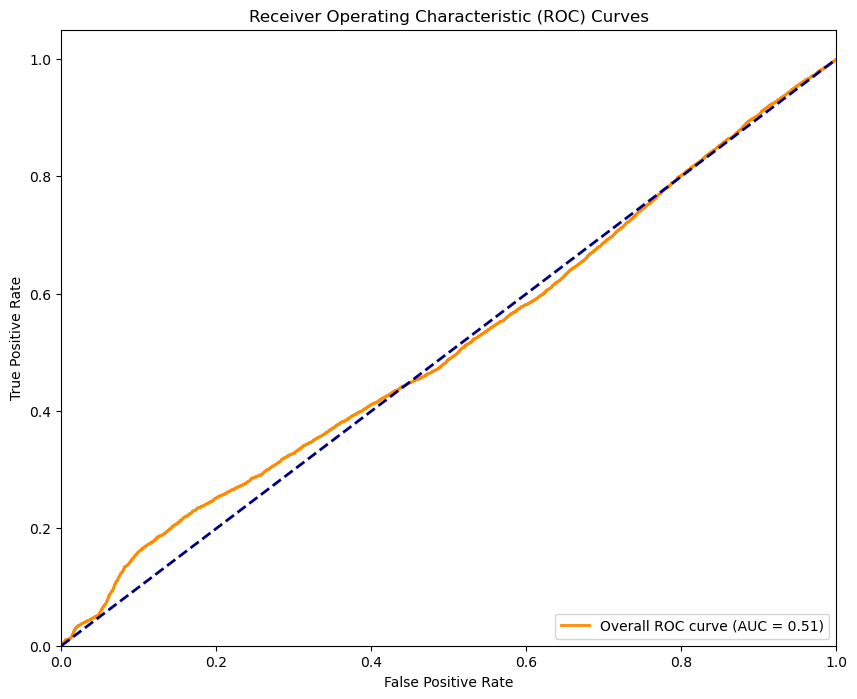

In [ ]:
# Main execution
data_folder = "../datasets/UTS/NAB"



noise_scheduler = SimplexNoiseScheduler(
    num_timesteps=config.num_timesteps,
    beta_start=config.beta_start,
    beta_end=config.beta_end,
    beta_schedule=config.beta_schedule
)

all_dir_results = []

for root, dirs, files in os.walk(data_folder):
    for dir in dirs:
        data_path = os.path.join(data_folder, dir)
        result = process_directory(sequence_length, stride, input_size, data_path, base_config, TCN, noise_scheduler)
        all_dir_results.append(result)

# Compute and plot overall metrics
all_labels = np.concatenate([res['labels'] for res in all_dir_results])
all_scores = np.concatenate([res['scores'] for res in all_dir_results])

print("\nOverall IQR outliers classification report")
print(classification_report(all_labels, (np.array(all_scores) > 1.5).astype(int)))

fpr, tpr, thresholds = roc_curve(all_labels, all_scores)
roc_auc = auc(fpr, tpr)

all_dir_results.append({
    'dir': 'Overall',
    'labels': all_labels,
    'scores': all_scores,
    'fpr': fpr,
    'tpr': tpr,
    'roc_auc': roc_auc
})

# Save results to CSV
results_df = pd.DataFrame(all_dir_results)
results_df.to_csv(os.path.join(config.output_dir, f"per_directory_roc_results_{config.num_epochs}.csv"))

# Plot ROC curves
plt.figure(figsize=(10, 8))
for res in all_dir_results:
    if res['dir'] == 'Overall':
        plt.plot(res['fpr'], res['tpr'], color='darkorange', lw=2, label=f"Overall (AUC = {res['roc_auc']:.2f})")
    else:
        plt.plot(res['fpr'], res['tpr'], lw=1, label=f"{res['dir']} (AUC = {res['roc_auc']:.2f})")

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.savefig(os.path.join(config.output_dir, f"one_by_one_roc_roc_curves_{config.num_epochs}.png"))
plt.close()

print(f"\nOverall ROC AUC: {roc_auc:.4f}")

# plot ans save only the overall roc curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Overall ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.savefig(os.path.join(config.output_dir, f"one_by_oneoverall_roc_curve_{config.num_epochs}.png"))
plt.show()

In [ ]:
# Extract AUC-ROC scores for the box plot
auc_scores = [res['roc_auc'] for res in all_dir_results if res['dir'] != 'Overall']

# Create the figure
plt.figure(figsize=(6, 8))  # Adjust the width to make it narrower

# Plot AUC-ROC box plot
sns.boxplot(y=auc_scores, color='lightpink', width=0.3)  # Reduced width for a narrower box

# Set the y-axis limits from 0 to 1
plt.ylim(0, 1)

# Customize the plot
plt.ylabel('AUC-ROC')
plt.title('Distribution of AUC-ROC Scores')

# Remove x-axis label and ticks
plt.xlabel('')
plt.xticks([])

# Add a grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Save the figure
plt.tight_layout()
plt.savefig(os.path.join(config.output_dir, f"one_b_one_auc_roc_distribution_{config.num_epochs}.png"))
plt.close()

# Print summary statistics
print(f"\nAUC-ROC Score Distribution:")
print(f"Mean: {np.mean(auc_scores):.4f}")
print(f"Median: {np.median(auc_scores):.4f}")
print(f"Min: {np.min(auc_scores):.4f}")
print(f"Max: {np.max(auc_scores):.4f}")


AUC-ROC Score Distribution:
Mean: 0.5590
Median: 0.5472
Min: 0.3770
Max: 0.6942



Processing directory: Twitter_volume_AAPL
Training:   7%|▋         | 1/15 [00:01<00:25,  1.83s/it]
Epoch 1/15, Loss: 42229.1817
Training:  13%|█▎        | 2/15 [00:03<00:22,  1.73s/it]
Epoch 2/15, Loss: 44746.9711
Training:  20%|██        | 3/15 [00:05<00:20,  1.70s/it]
Epoch 3/15, Loss: 44116.6374
Training:  27%|██▋       | 4/15 [00:06<00:18,  1.68s/it]
Epoch 4/15, Loss: 51059.4768
Training:  33%|███▎      | 5/15 [00:08<00:16,  1.67s/it]
Epoch 5/15, Loss: 42262.9729
Training:  40%|████      | 6/15 [00:10<00:15,  1.67s/it]
Epoch 6/15, Loss: 39686.9302
Training:  47%|████▋     | 7/15 [00:11<00:13,  1.66s/it]
Epoch 7/15, Loss: 40202.4508
Training:  53%|█████▎    | 8/15 [00:13<00:11,  1.66s/it]
Epoch 8/15, Loss: 48795.3583
Training:  60%|██████    | 9/15 [00:15<00:09,  1.66s/it]
Epoch 9/15, Loss: 40022.3921
Training:  67%|██████▋   | 10/15 [00:16<00:08,  1.65s/it]
Epoch 10/15, Loss: 50303.5952
Training:  73%|███████▎  | 11/15 [00:18<00:06,  1.66s/it]
Epoch 11/15, Loss: 37414.5113
Training:  80%|████████  | 12/15 [00:20<00:04,  1.66s/it]
Epoch 12/15, Loss: 37674.8271
Training:  87%|████████▋ | 13/15 [00:21<00:03,  1.66s/it]
Epoch 13/15, Loss: 43820.3433
Training:  93%|█████████▎| 14/15 [00:23<00:01,  1.66s/it]
Epoch 14/15, Loss: 46041.1267
Training: 100%|██████████| 15/15 [00:25<00:00,  1.67s/it]
Epoch 15/15, Loss: 38407.6061
Testing: 100%|██████████| 3/3 [00:00<00:00, 91.08it/s]

Classification report for Twitter_volume_AAPL
              precision    recall  f1-score   support

         0.0       0.96      0.92      0.94      7102
         1.0       0.20      0.34      0.25       398

    accuracy                           0.89      7500
   macro avg       0.58      0.63      0.60      7500
weighted avg       0.92      0.89      0.90      7500

ROC AUC: 0.6942

Processing directory: Twitter_volume_AMZN
Training:   7%|▋         | 1/15 [00:01<00:23,  1.71s/it]
Epoch 1/15, Loss: 2916.5832
Training:  13%|█▎        | 2/15 [00:03<00:21,  1.69s/it]
Epoch 2/15, Loss: 2457.9761
Training:  20%|██        | 3/15 [00:05<00:20,  1.71s/it]
Epoch 3/15, Loss: 2221.2066
Training:  27%|██▋       | 4/15 [00:06<00:18,  1.72s/it]
Epoch 4/15, Loss: 5006.7796
Training:  33%|███▎      | 5/15 [00:08<00:16,  1.69s/it]
Epoch 5/15, Loss: 1245.4381
Training:  40%|████      | 6/15 [00:10<00:15,  1.68s/it]
Epoch 6/15, Loss: 1645.6886
Training:  47%|████▋     | 7/15 [00:11<00:13,  1.68s/it]
Epoch 7/15, Loss: 1302.2262
Training:  53%|█████▎    | 8/15 [00:13<00:11,  1.67s/it]
Epoch 8/15, Loss: 1720.0120
Training:  60%|██████    | 9/15 [00:15<00:10,  1.72s/it]
Epoch 9/15, Loss: 1319.0858
Training:  67%|██████▋   | 10/15 [00:16<00:08,  1.71s/it]
Epoch 10/15, Loss: 1320.3957
Training:  73%|███████▎  | 11/15 [00:18<00:06,  1.70s/it]
Epoch 11/15, Loss: 1164.3470
Training:  80%|████████  | 12/15 [00:20<00:05,  1.69s/it]
Epoch 12/15, Loss: 1228.7935
Training:  87%|████████▋ | 13/15 [00:22<00:03,  1.68s/it]
Epoch 13/15, Loss: 1168.2222
Training:  93%|█████████▎| 14/15 [00:23<00:01,  1.68s/it]
Epoch 14/15, Loss: 1022.3484
Training: 100%|██████████| 15/15 [00:25<00:00,  1.69s/it]
Epoch 15/15, Loss: 1005.8052
Testing: 100%|██████████| 3/3 [00:00<00:00, 71.87it/s]

Classification report for Twitter_volume_AMZN
              precision    recall  f1-score   support

         0.0       0.90      0.96      0.93      6708
         1.0       0.29      0.13      0.18       792

    accuracy                           0.87      7500
   macro avg       0.60      0.55      0.56      7500
weighted avg       0.84      0.87      0.85      7500

ROC AUC: 0.5458

Processing directory: Twitter_volume_CRM
Training:   7%|▋         | 1/15 [00:02<00:28,  2.04s/it]
Epoch 1/15, Loss: 25.3052
Training:  13%|█▎        | 2/15 [00:03<00:23,  1.82s/it]
Epoch 2/15, Loss: 20.0142
Training:  20%|██        | 3/15 [00:05<00:20,  1.75s/it]
Epoch 3/15, Loss: 21.9377
Training:  27%|██▋       | 4/15 [00:07<00:18,  1.72s/it]
Epoch 4/15, Loss: 21.7008
Training:  33%|███▎      | 5/15 [00:08<00:16,  1.70s/it]
Epoch 5/15, Loss: 18.4080
Training:  40%|████      | 6/15 [00:10<00:15,  1.69s/it]
Epoch 6/15, Loss: 21.1503
Training:  47%|████▋     | 7/15 [00:12<00:13,  1.69s/it]
Epoch 7/15, Loss: 21.7631
Training:  53%|█████▎    | 8/15 [00:13<00:11,  1.68s/it]
Epoch 8/15, Loss: 19.4407
Training:  60%|██████    | 9/15 [00:15<00:10,  1.68s/it]
Epoch 9/15, Loss: 19.6417
Training:  67%|██████▋   | 10/15 [00:17<00:08,  1.68s/it]
Epoch 10/15, Loss: 22.4654
Training:  73%|███████▎  | 11/15 [00:18<00:06,  1.68s/it]
Epoch 11/15, Loss: 19.3895
Training:  80%|████████  | 12/15 [00:20<00:05,  1.67s/it]
Epoch 12/15, Loss: 21.5155
Training:  87%|████████▋ | 13/15 [00:22<00:03,  1.67s/it]
Epoch 13/15, Loss: 18.8013
Training:  93%|█████████▎| 14/15 [00:23<00:01,  1.67s/it]
Epoch 14/15, Loss: 22.6219
Training: 100%|██████████| 15/15 [00:25<00:00,  1.70s/it]
Epoch 15/15, Loss: 22.9758
Testing: 100%|██████████| 3/3 [00:00<00:00, 64.70it/s]

Classification report for Twitter_volume_CRM
              precision    recall  f1-score   support

         0.0       0.97      0.93      0.95      7151
         1.0       0.24      0.42      0.30       349

    accuracy                           0.91      7500
   macro avg       0.60      0.68      0.63      7500
weighted avg       0.94      0.91      0.92      7500

ROC AUC: 0.6937

Processing directory: Twitter_volume_CVS
Training:   7%|▋         | 1/15 [00:01<00:24,  1.74s/it]
Epoch 1/15, Loss: 0.9503
Training:  13%|█▎        | 2/15 [00:03<00:22,  1.70s/it]
Epoch 2/15, Loss: 0.7965
Training:  20%|██        | 3/15 [00:05<00:20,  1.69s/it]
Epoch 3/15, Loss: 0.8122
Training:  27%|██▋       | 4/15 [00:06<00:18,  1.68s/it]
Epoch 4/15, Loss: 0.7513
Training:  33%|███▎      | 5/15 [00:08<00:16,  1.68s/it]
Epoch 5/15, Loss: 0.7758
Training:  40%|████      | 6/15 [00:10<00:15,  1.67s/it]
Epoch 6/15, Loss: 0.7781
Training:  47%|████▋     | 7/15 [00:11<00:13,  1.67s/it]
Epoch 7/15, Loss: 0.8875
Training:  53%|█████▎    | 8/15 [00:13<00:11,  1.67s/it]
Epoch 8/15, Loss: 0.8329
Training:  60%|██████    | 9/15 [00:15<00:10,  1.67s/it]
Epoch 9/15, Loss: 0.7527
Training:  67%|██████▋   | 10/15 [00:16<00:08,  1.67s/it]
Epoch 10/15, Loss: 0.8319
Training:  73%|███████▎  | 11/15 [00:18<00:06,  1.67s/it]
Epoch 11/15, Loss: 0.8411
Training:  80%|████████  | 12/15 [00:20<00:05,  1.67s/it]
Epoch 12/15, Loss: 0.8204
Training:  87%|████████▋ | 13/15 [00:21<00:03,  1.67s/it]
Epoch 13/15, Loss: 0.7496
Training:  93%|█████████▎| 14/15 [00:23<00:01,  1.67s/it]
Epoch 14/15, Loss: 0.8436
Training: 100%|██████████| 15/15 [00:25<00:00,  1.68s/it]
Epoch 15/15, Loss: 0.8707
Testing: 100%|██████████| 3/3 [00:00<00:00, 70.73it/s]

Classification report for Twitter_volume_CVS
              precision    recall  f1-score   support

         0.0       0.88      0.59      0.71      6855
         1.0       0.04      0.17      0.06       645

    accuracy                           0.55      7500
   macro avg       0.46      0.38      0.38      7500
weighted avg       0.81      0.55      0.65      7500

ROC AUC: 0.3770

Processing directory: Twitter_volume_FB
Training:   7%|▋         | 1/15 [00:01<00:24,  1.78s/it]
Epoch 1/15, Loss: 303.3623
Training:  13%|█▎        | 2/15 [00:03<00:22,  1.72s/it]
Epoch 2/15, Loss: 239.7331
Training:  20%|██        | 3/15 [00:05<00:20,  1.69s/it]
Epoch 3/15, Loss: 207.0647
Training:  27%|██▋       | 4/15 [00:06<00:18,  1.69s/it]
Epoch 4/15, Loss: 194.6175
Training:  33%|███▎      | 5/15 [00:08<00:16,  1.69s/it]
Epoch 5/15, Loss: 197.5281
Training:  40%|████      | 6/15 [00:10<00:15,  1.68s/it]
Epoch 6/15, Loss: 202.5353
Training:  47%|████▋     | 7/15 [00:11<00:13,  1.68s/it]
Epoch 7/15, Loss: 208.7332
Training:  53%|█████▎    | 8/15 [00:13<00:11,  1.68s/it]
Epoch 8/15, Loss: 174.3658
Training:  60%|██████    | 9/15 [00:15<00:10,  1.68s/it]
Epoch 9/15, Loss: 204.6901
Training:  67%|██████▋   | 10/15 [00:16<00:08,  1.68s/it]
Epoch 10/15, Loss: 188.2912
Training:  73%|███████▎  | 11/15 [00:18<00:06,  1.68s/it]
Epoch 11/15, Loss: 184.1315
Training:  80%|████████  | 12/15 [00:20<00:05,  1.67s/it]
Epoch 12/15, Loss: 176.3123
Training:  87%|████████▋ | 13/15 [00:21<00:03,  1.67s/it]
Epoch 13/15, Loss: 193.5103
Training:  93%|█████████▎| 14/15 [00:23<00:01,  1.67s/it]
Epoch 14/15, Loss: 172.6576
Training: 100%|██████████| 15/15 [00:25<00:00,  1.68s/it]
Epoch 15/15, Loss: 190.2298
Testing: 100%|██████████| 3/3 [00:00<00:00, 71.69it/s]

Classification report for Twitter_volume_FB
              precision    recall  f1-score   support

         0.0       0.89      0.92      0.91      6708
         1.0       0.06      0.04      0.05       792

    accuracy                           0.83      7500
   macro avg       0.47      0.48      0.48      7500
weighted avg       0.80      0.83      0.82      7500

ROC AUC: 0.4241

Processing directory: Twitter_volume_GOOG
Training:   7%|▋         | 1/15 [00:01<00:24,  1.76s/it]
Epoch 1/15, Loss: 610.4283
Training:  13%|█▎        | 2/15 [00:03<00:22,  1.71s/it]
Epoch 2/15, Loss: 427.1725
Training:  20%|██        | 3/15 [00:05<00:20,  1.69s/it]
Epoch 3/15, Loss: 1002.3773
Training:  27%|██▋       | 4/15 [00:06<00:18,  1.69s/it]
Epoch 4/15, Loss: 384.8271
Training:  33%|███▎      | 5/15 [00:08<00:16,  1.68s/it]
Epoch 5/15, Loss: 341.5805
Training:  40%|████      | 6/15 [00:10<00:15,  1.67s/it]
Epoch 6/15, Loss: 313.1538
Training:  47%|████▋     | 7/15 [00:12<00:14,  1.76s/it]
Epoch 7/15, Loss: 308.1556
Training:  53%|█████▎    | 8/15 [00:13<00:12,  1.81s/it]
Epoch 8/15, Loss: 296.9814
Training:  60%|██████    | 9/15 [00:15<00:10,  1.77s/it]
Epoch 9/15, Loss: 299.3254
Training:  67%|██████▋   | 10/15 [00:17<00:08,  1.74s/it]
Epoch 10/15, Loss: 446.9736
Training:  73%|███████▎  | 11/15 [00:18<00:06,  1.72s/it]
Epoch 11/15, Loss: 310.2745
Training:  80%|████████  | 12/15 [00:20<00:05,  1.71s/it]
Epoch 12/15, Loss: 261.8674
Training:  87%|████████▋ | 13/15 [00:22<00:03,  1.70s/it]
Epoch 13/15, Loss: 309.0286
Training:  93%|█████████▎| 14/15 [00:24<00:01,  1.69s/it]
Epoch 14/15, Loss: 287.0986
Training: 100%|██████████| 15/15 [00:25<00:00,  1.71s/it]
Epoch 15/15, Loss: 316.6017
Testing: 100%|██████████| 3/3 [00:00<00:00, 89.67it/s]

Classification report for Twitter_volume_GOOG
              precision    recall  f1-score   support

         0.0       0.96      0.93      0.95      7102
         1.0       0.24      0.39      0.30       398

    accuracy                           0.90      7500
   macro avg       0.60      0.66      0.62      7500
weighted avg       0.93      0.90      0.91      7500

ROC AUC: 0.6682

Processing directory: Twitter_volume_IBM
Training:   7%|▋         | 1/15 [00:01<00:24,  1.74s/it]
Epoch 1/15, Loss: 16.6167
Training:  13%|█▎        | 2/15 [00:03<00:22,  1.70s/it]
Epoch 2/15, Loss: 13.9541
Training:  20%|██        | 3/15 [00:05<00:20,  1.69s/it]
Epoch 3/15, Loss: 14.1983
Training:  27%|██▋       | 4/15 [00:06<00:18,  1.68s/it]
Epoch 4/15, Loss: 14.7585
Training:  33%|███▎      | 5/15 [00:08<00:16,  1.68s/it]
Epoch 5/15, Loss: 15.1578
Training:  40%|████      | 6/15 [00:10<00:15,  1.67s/it]
Epoch 6/15, Loss: 15.3439
Training:  47%|████▋     | 7/15 [00:11<00:13,  1.67s/it]
Epoch 7/15, Loss: 14.6894
Training:  53%|█████▎    | 8/15 [00:13<00:11,  1.67s/it]
Epoch 8/15, Loss: 13.2588
Training:  60%|██████    | 9/15 [00:15<00:10,  1.67s/it]
Epoch 9/15, Loss: 14.2992
Training:  67%|██████▋   | 10/15 [00:16<00:08,  1.67s/it]
Epoch 10/15, Loss: 13.2267
Training:  73%|███████▎  | 11/15 [00:18<00:06,  1.67s/it]
Epoch 11/15, Loss: 13.1212
Training:  80%|████████  | 12/15 [00:20<00:05,  1.71s/it]
Epoch 12/15, Loss: 13.9849
Training:  87%|████████▋ | 13/15 [00:22<00:03,  1.73s/it]
Epoch 13/15, Loss: 14.3838
Training:  93%|█████████▎| 14/15 [00:23<00:01,  1.71s/it]
Epoch 14/15, Loss: 14.0517
Training: 100%|██████████| 15/15 [00:25<00:00,  1.69s/it]
Epoch 15/15, Loss: 14.1184
Testing: 100%|██████████| 3/3 [00:00<00:00, 88.43it/s]

Classification report for Twitter_volume_IBM
              precision    recall  f1-score   support

         0.0       0.93      0.94      0.93      6902
         1.0       0.16      0.14      0.15       598

    accuracy                           0.87      7500
   macro avg       0.54      0.54      0.54      7500
weighted avg       0.86      0.87      0.87      7500

ROC AUC: 0.4989

Processing directory: Twitter_volume_KO
Training:   7%|▋         | 1/15 [00:01<00:24,  1.72s/it]
Epoch 1/15, Loss: 261.4323
Training:  13%|█▎        | 2/15 [00:03<00:21,  1.69s/it]
Epoch 2/15, Loss: 225.8539
Training:  20%|██        | 3/15 [00:05<00:20,  1.68s/it]
Epoch 3/15, Loss: 191.4482
Training:  27%|██▋       | 4/15 [00:06<00:18,  1.68s/it]
Epoch 4/15, Loss: 191.7684
Training:  33%|███▎      | 5/15 [00:08<00:16,  1.68s/it]
Epoch 5/15, Loss: 169.2435
Training:  40%|████      | 6/15 [00:10<00:15,  1.68s/it]
Epoch 6/15, Loss: 171.4989
Training:  47%|████▋     | 7/15 [00:11<00:13,  1.68s/it]
Epoch 7/15, Loss: 202.2852
Training:  53%|█████▎    | 8/15 [00:13<00:11,  1.68s/it]
Epoch 8/15, Loss: 191.0442
Training:  60%|██████    | 9/15 [00:15<00:10,  1.68s/it]
Epoch 9/15, Loss: 176.0686
Training:  67%|██████▋   | 10/15 [00:16<00:08,  1.68s/it]
Epoch 10/15, Loss: 233.6723
Training:  73%|███████▎  | 11/15 [00:18<00:06,  1.68s/it]
Epoch 11/15, Loss: 211.3257
Training:  80%|████████  | 12/15 [00:20<00:05,  1.68s/it]
Epoch 12/15, Loss: 202.4466
Training:  87%|████████▋ | 13/15 [00:21<00:03,  1.68s/it]
Epoch 13/15, Loss: 197.5507
Training:  93%|█████████▎| 14/15 [00:23<00:01,  1.68s/it]
Epoch 14/15, Loss: 184.2519
Training: 100%|██████████| 15/15 [00:25<00:00,  1.68s/it]
Epoch 15/15, Loss: 201.3366
Testing: 100%|██████████| 3/3 [00:00<00:00, 89.60it/s]

Classification report for Twitter_volume_KO
              precision    recall  f1-score   support

         0.0       0.86      0.93      0.89      6440
         1.0       0.15      0.08      0.10      1060

    accuracy                           0.81      7500
   macro avg       0.51      0.50      0.50      7500
weighted avg       0.76      0.81      0.78      7500

ROC AUC: 0.5174

Processing directory: Twitter_volume_PFE
Training:   7%|▋         | 1/15 [00:01<00:24,  1.73s/it]
Epoch 1/15, Loss: 2.2984
Training:  13%|█▎        | 2/15 [00:03<00:22,  1.70s/it]
Epoch 2/15, Loss: 2.0439
Training:  20%|██        | 3/15 [00:05<00:21,  1.76s/it]
Epoch 3/15, Loss: 1.8802
Training:  27%|██▋       | 4/15 [00:06<00:19,  1.73s/it]
Epoch 4/15, Loss: 2.0176
Training:  33%|███▎      | 5/15 [00:08<00:17,  1.71s/it]
Epoch 5/15, Loss: 2.0234
Training:  40%|████      | 6/15 [00:10<00:15,  1.70s/it]
Epoch 6/15, Loss: 1.9389
Training:  47%|████▋     | 7/15 [00:11<00:13,  1.69s/it]
Epoch 7/15, Loss: 1.8041
Training:  53%|█████▎    | 8/15 [00:13<00:11,  1.69s/it]
Epoch 8/15, Loss: 1.9486
Training:  60%|██████    | 9/15 [00:15<00:10,  1.69s/it]
Epoch 9/15, Loss: 1.9100
Training:  67%|██████▋   | 10/15 [00:17<00:08,  1.77s/it]
Epoch 10/15, Loss: 1.8416
Training:  73%|███████▎  | 11/15 [00:18<00:06,  1.75s/it]
Epoch 11/15, Loss: 1.8382
Training:  80%|████████  | 12/15 [00:20<00:05,  1.73s/it]
Epoch 12/15, Loss: 1.8925
Training:  87%|████████▋ | 13/15 [00:22<00:03,  1.72s/it]
Epoch 13/15, Loss: 1.7367
Training:  93%|█████████▎| 14/15 [00:24<00:01,  1.71s/it]
Epoch 14/15, Loss: 1.7476
Training: 100%|██████████| 15/15 [00:25<00:00,  1.71s/it]
Epoch 15/15, Loss: 1.9024
Testing: 100%|██████████| 3/3 [00:00<00:00, 70.06it/s]

Classification report for Twitter_volume_PFE
              precision    recall  f1-score   support

         0.0       0.95      0.91      0.93      7102
         1.0       0.09      0.16      0.12       398

    accuracy                           0.87      7500
   macro avg       0.52      0.54      0.52      7500
weighted avg       0.91      0.87      0.89      7500

ROC AUC: 0.5485

Processing directory: Twitter_volume_UPS
Training:   7%|▋         | 1/15 [00:01<00:25,  1.83s/it]
Epoch 1/15, Loss: 630.7435
Training:  13%|█▎        | 2/15 [00:03<00:22,  1.74s/it]
Epoch 2/15, Loss: 489.7348
Training:  20%|██        | 3/15 [00:05<00:20,  1.71s/it]
Epoch 3/15, Loss: 585.6480
Training:  27%|██▋       | 4/15 [00:06<00:18,  1.69s/it]
Epoch 4/15, Loss: 575.2720
Training:  33%|███▎      | 5/15 [00:08<00:16,  1.69s/it]
Epoch 5/15, Loss: 760.0235
Training:  40%|████      | 6/15 [00:10<00:15,  1.69s/it]
Epoch 6/15, Loss: 616.3477
Training:  47%|████▋     | 7/15 [00:11<00:13,  1.69s/it]
Epoch 7/15, Loss: 553.8804
Training:  53%|█████▎    | 8/15 [00:13<00:12,  1.76s/it]
Epoch 8/15, Loss: 586.4690
Training:  60%|██████    | 9/15 [00:15<00:10,  1.73s/it]
Epoch 9/15, Loss: 605.6497
Training:  67%|██████▋   | 10/15 [00:17<00:08,  1.71s/it]
Epoch 10/15, Loss: 610.6687
Training:  73%|███████▎  | 11/15 [00:18<00:06,  1.71s/it]
Epoch 11/15, Loss: 549.1706
Training:  80%|████████  | 12/15 [00:20<00:05,  1.71s/it]
Epoch 12/15, Loss: 503.5544
Training:  87%|████████▋ | 13/15 [00:22<00:03,  1.70s/it]
Epoch 13/15, Loss: 607.1083
Training:  93%|█████████▎| 14/15 [00:23<00:01,  1.69s/it]
Epoch 14/15, Loss: 546.8552
Training: 100%|██████████| 15/15 [00:25<00:00,  1.71s/it]
Epoch 15/15, Loss: 531.8645
Testing: 100%|██████████| 3/3 [00:00<00:00, 69.87it/s]

Classification report for Twitter_volume_UPS
              precision    recall  f1-score   support

         0.0       0.97      0.73      0.83      7182
         1.0       0.07      0.44      0.12       318

    accuracy                           0.72      7500
   macro avg       0.52      0.59      0.48      7500
weighted avg       0.93      0.72      0.80      7500

ROC AUC: 0.6224

Overall IQR outliers classification report
              precision    recall  f1-score   support

         0.0       0.93      0.88      0.90     69252
         1.0       0.11      0.18      0.14      5748

    accuracy                           0.82     75000
   macro avg       0.52      0.53      0.52     75000
weighted avg       0.87      0.82      0.84     75000



Overall ROC AUC: 0.5107

# Yahoo dataset - all in one 

In [ ]:
# config for Yahoo dataset
base_config = {
  "data_path":  "../datasets/UTS/Yahoo1",
  "output_dir": "output_Yahoo1_simplex1",
  "train_batch_size": 32,
  "eval_batch_size": 1,
  "num_epochs": 15,
  
  "learning_rate": 0.0001,
  "num_timesteps": 100,
  "beta_schedule": "linear",
  "embedding_size": 128,
  "hidden_size": 128,
  "hidden_layers": 3,
  "time_embedding": "sinusoidal",
  "input_embedding": "sinusoidal",
  "save_eval_step": 10,
  "experiment_name": "NonName",
  "beta_start": 0.05,
  "beta_end": 0.3,
  "save_model_epochs": 1
}

sequence_length = 100
input_size = 1  # Assuming 1D time series data
stride = 10


In [ ]:
# all in one training and testing
import os
    
config = Config(base_config)

# Initialize the new TCN model
model = TCN(
    num_inputs=input_size,  # Number of input channels
    num_channels=[32, 64, 128,256,128,64,32,1],  # Number of channels in each residual block
    kernel_size=3,  # Size of the convolution kernel
    dilations=None,  # Dilation sizes
    dilation_reset=None,  # Reset dilation size
    dropout=0.2,  # Dropout rate
    causal=True,  # Causal convolutions for real-time applications
    use_norm='weight_norm',  # Normalization method
    activation='relu',  # Activation function
    kernel_initializer='xavier_uniform',  # Weight initializer
    use_skip_connections=False,  # Skip connections
    input_shape='NLC',  # Input shape format ('NCL' or 'NLC') [16, 5000, 1] for NLC
    embedding_shapes=None,  # Embedding shapes
    embedding_mode='add',  # Embedding mode ('add' or 'concat')
    use_gate=False,  # Use gated linear unit
    lookahead=0,  # Lookahead for future time steps
    output_projection=None,  # Output projection
    output_activation=None,  # Output activation
)

noise_scheduler = SimplexNoiseScheduler(
    num_timesteps=config.num_timesteps,
    beta_start=config.beta_start,
    beta_end=config.beta_end,
    beta_schedule=config.beta_schedule
)

data_folder = config.data_path
print(data_folder)

#================================================================================================
# train the model and test it

model, losses = trainer_all_in_one(sequence_length, stride,base_config, config, model, noise_scheduler, data_folder)


In [ ]:
# evaluation with roc curve and classification report 
from sklearn.metrics import classification_report, roc_curve, auc

model.eval()
eval_batch_size = config.eval_batch_size

all_dir_results = []

for root, dirs, files in os.walk(data_folder):
    for dir in dirs:
        data_path = os.path.join(data_folder, dir)
        print(f"\nProcessing directory: {dir}")
    
        # change datapath in the config
        base_config["data_path"] = data_path
        config = Config(base_config)
        
        # Set up dataset and dataloader for test data
        test_dataset = TimeSeriesTestDataset(config.data_path, sequence_length=sequence_length , stride=sequence_length , normalize=False)
        print("Number of batches:", len(test_dataset))

        # Create dataloader for the test dataset
        test_dataloader = DataLoader(test_dataset, batch_size=config.eval_batch_size, shuffle=False, drop_last=True)

        all_labels = []
        all_scores = []

        for step, (sample, labels) in enumerate(tqdm(test_dataloader)):
            std_data = torch.std(sample)
            
            with torch.no_grad():
                timesteps = torch.tensor([50])
                
                noise = torch.randn_like(sample) 
                noisy_sample = noise_scheduler.add_noise(sample, noise, timesteps)
                
                noisy_sample = noisy_sample.unsqueeze(-1)
                sample = sample.unsqueeze(-1)
                denoised_sample = model(noisy_sample)

                # Calculate IQR outliers
                iqr_out, iqr_scores = iqr_outliers(sample, denoised_sample)
                
                labels = labels.cpu().numpy()

                # Store labels and scores
                all_labels.extend(labels.reshape(-1))
                all_scores.extend(iqr_scores.reshape(-1))

        # Calculate metrics for this directory
        fpr, tpr, thresholds = roc_curve(all_labels, all_scores)
        roc_auc = auc(fpr, tpr)
        
        print("\nIQR outliers classification report for", dir)
        print(classification_report(all_labels, (np.array(all_scores) > 1.5).astype(int)))
        print(f"ROC AUC: {roc_auc:.4f}")

        # Store results for this directory
        all_dir_results.append({
            'dir': dir,
            'labels': all_labels,
            'scores': all_scores,
            'fpr': fpr,
            'tpr': tpr,
            'roc_auc': roc_auc
        })

# Compute overall metrics
all_labels = np.concatenate([res['labels'] for res in all_dir_results])
all_scores = np.concatenate([res['scores'] for res in all_dir_results])

print("\nOverall IQR outliers classification report")
print(classification_report(all_labels, (np.array(all_scores) > 2).astype(int)))

for density_threshold in range(5 , 25, 2):
    print(f"\nDensity threshold: {density_threshold}")
    print(classification_report(all_labels, (np.array(all_scores) > density_threshold*0.1).astype(int)))

fpr, tpr, thresholds = roc_curve(all_labels, all_scores)
roc_auc = auc(fpr, tpr)

all_dir_results.append({
    'dir': 'Overall',
    'labels': all_labels,
    'scores': all_scores,
    'fpr': fpr,
    'tpr': tpr,
    'roc_auc': roc_auc
})

#save the results in a csv file
results_df = pd.DataFrame(all_dir_results)
results_df.to_csv(os.path.join(config.output_dir, f"allinone_roc_resultsf{config.num_epochs}.csv"))

# Plot overall ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Overall ROC curve (AUC = {roc_auc:.2f})')

# Plot ROC curves for each directory
for res in all_dir_results:
    plt.plot(res['fpr'], res['tpr'], lw=1, label=f"{res['dir']} (AUC = {res['roc_auc']:.2f})")

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.savefig(os.path.join(config.output_dir, f"all_in_one_roc_curves_{config.num_epochs}.png"))
plt.legend(loc="lower right")
plt.show()


print(f"\nOverall ROC AUC: {roc_auc:.4f}")

# plot ans save only the overall roc curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Overall ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.savefig(os.path.join(config.output_dir, f"all_in_one_overall_roc_curve_{config.num_epochs}.png"))
plt.show()

In [ ]:
# ROC AUC score distribution
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming all_dir_results is already populated with results from each directory

# Extract AUC-ROC scores for the box plot
auc_scores = [res['roc_auc'] for res in all_dir_results if res['dir'] != 'Overall']

# Create the figure
plt.figure(figsize=(6, 8))  # Adjust the width to make it narrower

# Plot AUC-ROC box plot
sns.boxplot(y=auc_scores, color='lightpink', width=0.3)  # Reduced width for a narrower box

# Set the y-axis limits from 0 to 1
plt.ylim(0, 1)

# Customize the plot
plt.ylabel('AUC-ROC')
plt.title('Distribution of AUC-ROC Scores')

# Remove x-axis label and ticks
plt.xlabel('')
plt.xticks([])

# Add a grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Save the figure
plt.tight_layout()
plt.savefig(os.path.join(config.output_dir, f"allin_one_auc_roc_distribution_{config.num_epochs}.png"))
plt.close()

# Print summary statistics
print(f"\nAUC-ROC Score Distribution:")
print(f"Mean: {np.mean(auc_scores):.4f}")
print(f"Median: {np.median(auc_scores):.4f}")
print(f"Min: {np.min(auc_scores):.4f}")
print(f"Max: {np.max(auc_scores):.4f}")

# Yahoo dataset - one by one 

In [ ]:
all_dir_results = []

for root, dirs, files in os.walk(data_folder):
    for dir in dirs:
        data_path = os.path.join(data_folder, dir)
        result = process_directory(sequence_length, stride, input_size, data_path, base_config, TCN, noise_scheduler)
        all_dir_results.append(result)

# Compute and plot overall metrics
all_labels = np.concatenate([res['labels'] for res in all_dir_results])
all_scores = np.concatenate([res['scores'] for res in all_dir_results])

print("\nOverall IQR outliers classification report")
print(classification_report(all_labels, (np.array(all_scores) > 2).astype(int)))

fpr, tpr, thresholds = roc_curve(all_labels, all_scores)
roc_auc = auc(fpr, tpr)

all_dir_results.append({
    'dir': 'Overall',
    'labels': all_labels,
    'scores': all_scores,
    'fpr': fpr,
    'tpr': tpr,
    'roc_auc': roc_auc
})

# Save results to CSV
results_df = pd.DataFrame(all_dir_results)
results_df.to_csv(os.path.join(config.output_dir, f"per_directory_roc_results_{config.num_epochs}.csv"))

# Plot ROC curves
plt.figure(figsize=(10, 8))
for res in all_dir_results:
    if res['dir'] == 'Overall':
        plt.plot(res['fpr'], res['tpr'], color='darkorange', lw=2, label=f"Overall (AUC = {res['roc_auc']:.2f})")
    else:
        plt.plot(res['fpr'], res['tpr'], lw=1, label=f"{res['dir']} (AUC = {res['roc_auc']:.2f})")

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.savefig(os.path.join(config.output_dir, f"one_by_one_roc_curves_{config.num_epochs}.png"))
plt.close()

print(f"\nOverall ROC AUC: {roc_auc:.4f}")

# plot ans save only the overall roc curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Overall ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.savefig(os.path.join(config.output_dir, f"one_by_oneoverall_roc_curve_{config.num_epochs}.png"))
plt.show()

In [ ]:
# Extract AUC-ROC scores for the box plot
auc_scores = [res['roc_auc'] for res in all_dir_results if res['dir'] != 'Overall']

# Create the figure
plt.figure(figsize=(6, 8))  # Adjust the width to make it narrower

# Plot AUC-ROC box plot
sns.boxplot(y=auc_scores, color='lightpink', width=0.3)  # Reduced width for a narrower box

# Set the y-axis limits from 0 to 1
plt.ylim(0, 1)

# Customize the plot
plt.ylabel('AUC-ROC')
plt.title('Distribution of AUC-ROC Scores')

# Remove x-axis label and ticks
plt.xlabel('')
plt.xticks([])

# Add a grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Save the figure
plt.tight_layout()
plt.savefig(os.path.join(config.output_dir, f"one_b_one_auc_roc_distribution_{config.num_epochs}.png"))
plt.close()

# Print summary statistics
print(f"\nAUC-ROC Score Distribution:")
print(f"Mean: {np.mean(auc_scores):.4f}")
print(f"Median: {np.median(auc_scores):.4f}")
print(f"Min: {np.min(auc_scores):.4f}")
print(f"Max: {np.max(auc_scores):.4f}")